# Subject Invariant Activity Recognition using SVMs

## 1. Introduction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Display settings for pandas
pd.set_option('display.max_columns', None)

# Subject Invariant Activity Recognition using SVMs

## 1. Introduction

This notebook presents a comprehensive analysis of subject-invariant activity recognition using Support Vector Machines (SVMs). The goal is to develop models that can accurately recognize physical activities performed by subjects who were not seen during training.

### Background
Wearable sensors provide valuable data for recognizing human activities, with applications in healthcare, fitness tracking, and human-computer interaction. A key challenge in this domain is developing models that generalize well across different individuals, as people perform the same activities with different styles, speeds, and physical characteristics.

### Activities
We'll be working with data from 10 subjects performing 6 physical activities:
1. Walking
2. Walking Upstairs
3. Walking Downstairs
4. Sitting
5. Standing
6. Laying

### Objectives
We'll develop and compare three SVM-based models:
1. SVM on the original 561-dimensional feature space
2. SVM on PCA-reduced data (retaining 95% variance)
3. SVM on LDA-reduced data

Using a 5-fold subject-wise cross-validation approach, we'll evaluate how well these models generalize to unseen subjects. This approach is more realistic than random splits, as it simulates real-world deployment where the model must work for new users.

### Dimensionality Reduction
Dimensionality reduction techniques like PCA and LDA can potentially improve generalization by:
- Reducing overfitting to subject-specific characteristics
- Focusing on the most important features for activity discrimination
- Improving computational efficiency

Let's begin by exploring the dataset and preparing it for modeling.

In [3]:
## 2. Data Loading & Preprocessing

# Load the datasets
signal_data = pd.read_csv('wearables_signal.csv', header=None)
activity_data = pd.read_csv('wearables_activity.csv', header=None)
subject_data = pd.read_csv('wearables_subject.csv', header=None)

# Display basic information
print(f"Signal data shape: {signal_data.shape}")
print(f"Activity data shape: {activity_data.shape}")
print(f"Subject data shape: {subject_data.shape}")

# Rename columns for clarity
signal_data.columns = [f'feature_{i}' for i in range(signal_data.shape[1])]
activity_data.columns = ['activity']
subject_data.columns = ['subject']

# Merge datasets
data = pd.concat([signal_data, activity_data, subject_data], axis=1)

# Map activity labels to descriptive names
activity_mapping = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}
data['activity_name'] = data['activity'].map(activity_mapping)

# Display sample of the merged dataset
data.head()

Signal data shape: (3237, 561)
Activity data shape: (3237, 1)
Subject data shape: (3237, 1)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_83,feature_84,feature_85,feature_86,feature_87,feature_88,feature_89,feature_90,feature_91,feature_92,feature_93,feature_94,feature_95,feature_96,feature_97,feature_98,feature_99,feature_100,feature_101,feature_102,feature_103,feature_104,feature_105,feature_106,feature_107,feature_108,feature_109,feature_110,feature_111,feature_112,feature_113,feature_114,feature_115,feature_116,feature_117,feature_118,feature_119,feature_120,feature_121,feature_122,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,feature_130,feature_131,feature_132,feature_133,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143,feature_144,feature_145,feature_146,feature_147,feature_148,feature_149,feature_150,feature_151,feature_152,feature_153,feature_154,feature_155,feature_156,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167,feature_168,feature_169,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179,feature_180,feature_181,feature_182,feature_183,feature_184,feature_185,feature_186,feature_187,feature_188,feature_189,feature_190,feature_191,feature_192,feature_193,feature_194,feature_195,feature_196,feature_197,feature_198,feature_199,feature_200,feature_201,feature_202,feature_203,feature_204,feature_205,feature_206,feature_207,feature_208,feature_209,feature_210,feature_211,feature_212,feature_213,feature_214,feature_215,feature_216,feature_217,feature_218,feature_219,feature_220,feature_221,feature_222,feature_223,feature_224,feature_225,feature_226,feature_227,feature_228,feature_229,feature_230,feature_231,feature_232,feature_233,feature_234,feature_235,feature_236,feature_237,feature_238,feature_239,feature_240,feature_241,feature_242,feature_243,feature_244,feature_245,feature_246,feature_247,feature_248,feature_249,feature_250,feature_251,feature_252,feature_253,feature_254,feature_255,feature_256,feature_257,feature_258,feature_259,feature_260,feature_261,feature_262,feature_263,feature_264,feature_265,feature_266,feature_267,feature_268,feature_269,feature_270,feature_271,feature_272,feature_273,feature_274,feature_275,feature_276,feature_277,feature_278,feature_279,feature_280,feature_281,feature_282,feature_283,feature_284,feature_285,feature_286,feature_287,feature_288,feature_289,feature_290,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,feature_301,feature_302,feature_303,feature_304,feature_305,feature_306,feature_307,feature_308,feature_309,feature_310,feature_311,feature_312,feature_313,feature_314,feature_315,feature_316,feature_317,feature_318,feature_319,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329,feature_330,feature_331,feature_332,feature_333,feature_334,feature_335,feature_336,feature_337,feature_338,feature_339,feature_340,feature_341,featu

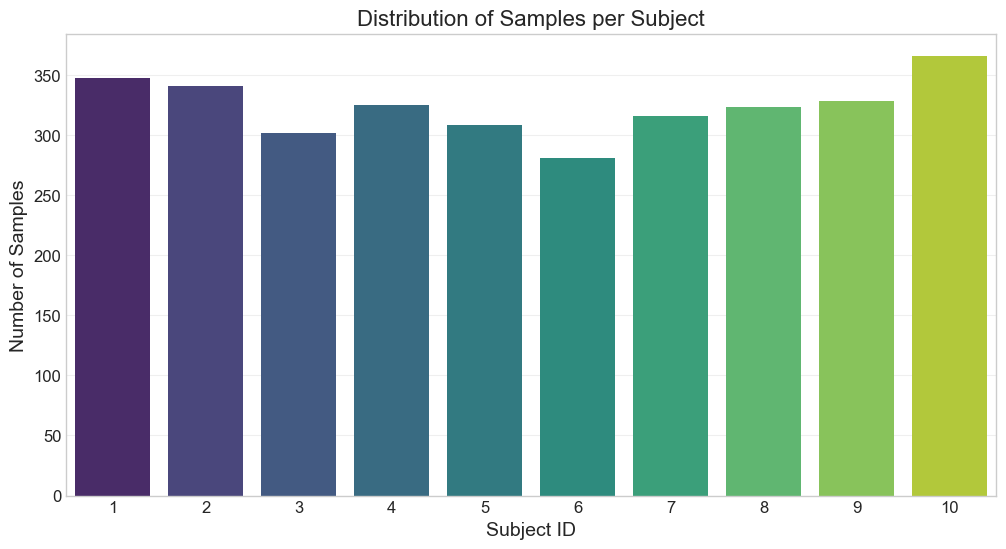

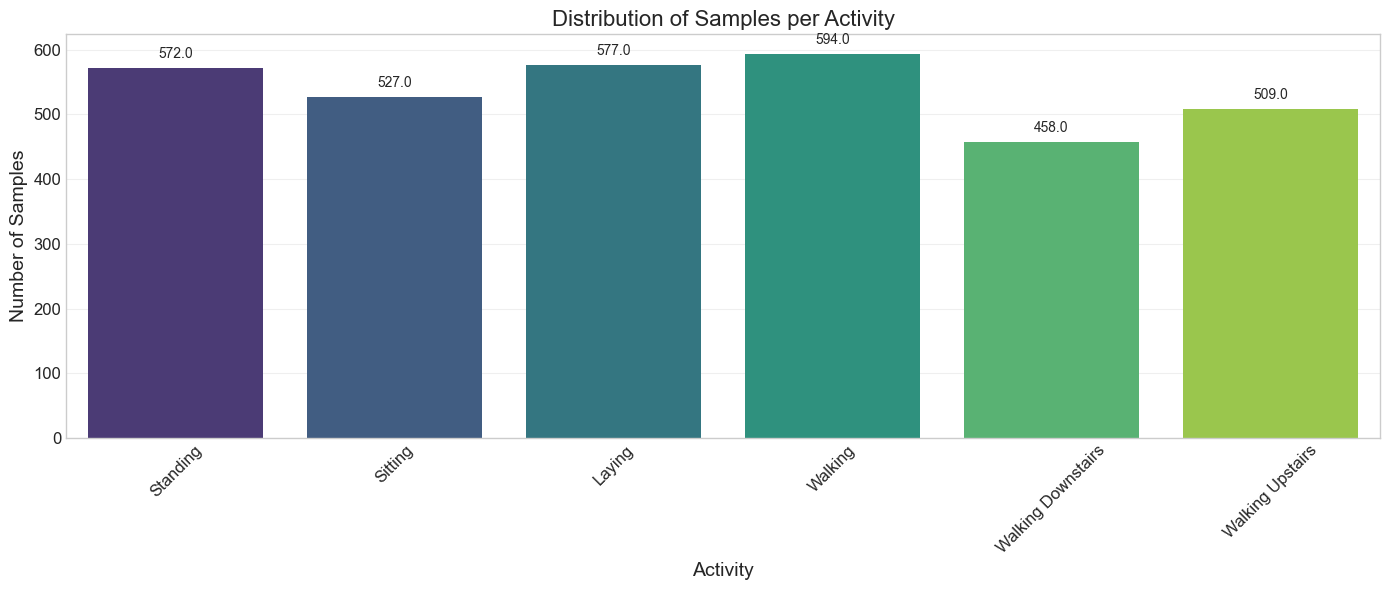

<Figure size 1600x800 with 0 Axes>

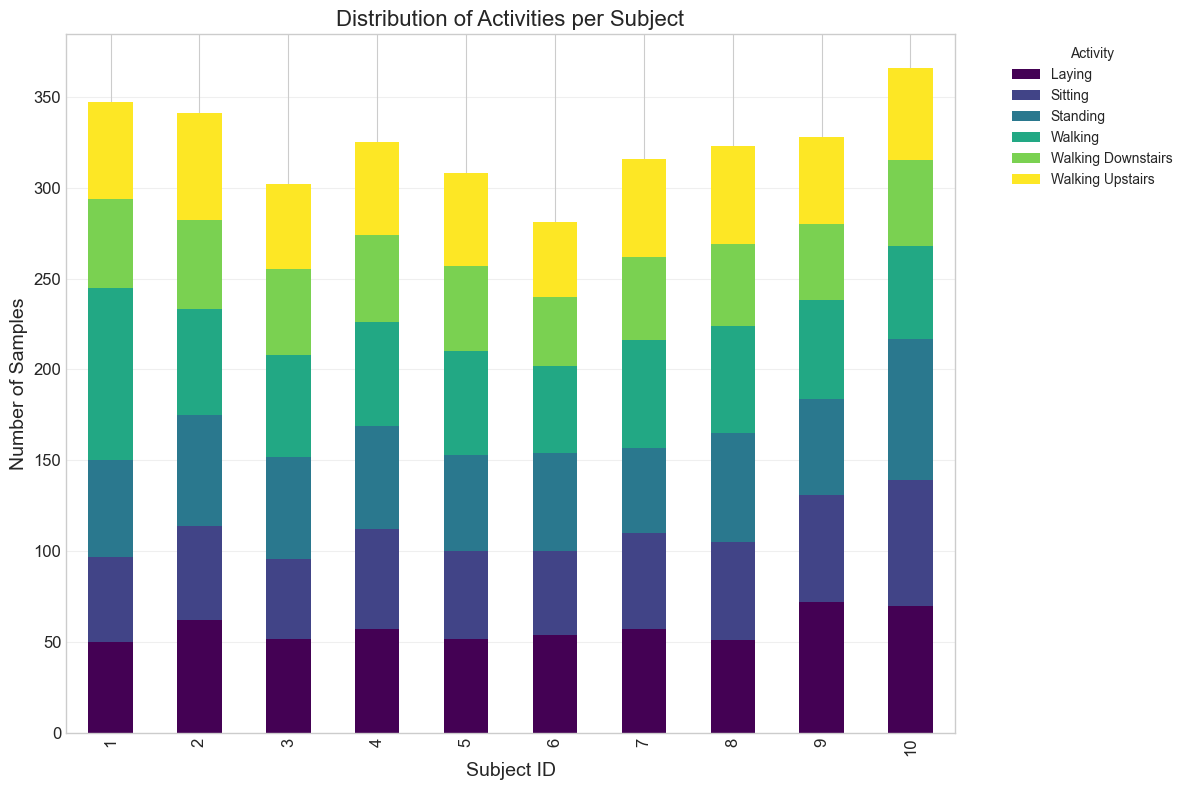

Original feature space shape: (3237, 561)
Number of unique activities: 6
Number of unique subjects: 10


In [4]:
# Visualize distribution of samples per subject
plt.figure(figsize=(12, 6))
sns.countplot(x='subject', data=data, palette='viridis')
plt.title('Distribution of Samples per Subject')
plt.xlabel('Subject ID')
plt.ylabel('Number of Samples')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Visualize distribution of samples per activity
plt.figure(figsize=(14, 6))
ax = sns.countplot(x='activity_name', data=data, palette='viridis')
plt.title('Distribution of Samples per Activity')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')
plt.tight_layout()
plt.show()

# Visualize distribution of activities per subject
plt.figure(figsize=(16, 8))
activity_by_subject = pd.crosstab(data['subject'], data['activity_name'])
activity_by_subject.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Activities per Subject')
plt.xlabel('Subject ID')
plt.ylabel('Number of Samples')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Prepare data for modeling
X = data.iloc[:, :561]  # Features
y = data['activity']    # Target
subjects = data['subject']

# Encode activity labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original feature space shape:", X.shape)
print("Number of unique activities:", len(np.unique(y)))
print("Number of unique subjects:", len(np.unique(subjects)))

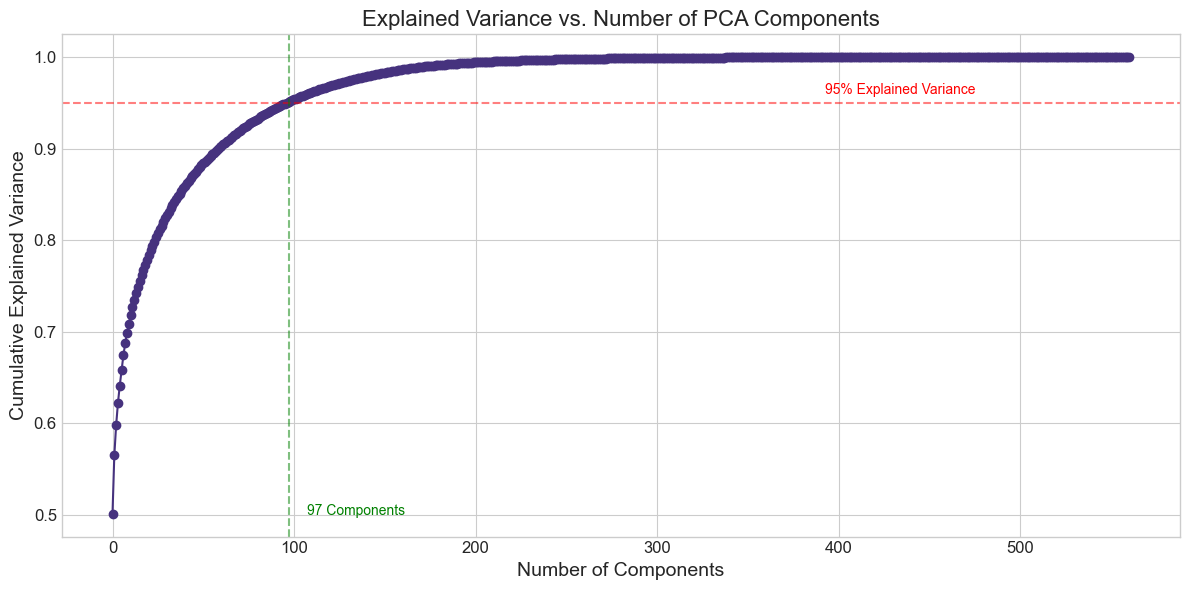

Number of components needed for 95% variance: 97
Reduced PCA feature space shape: (3237, 97)


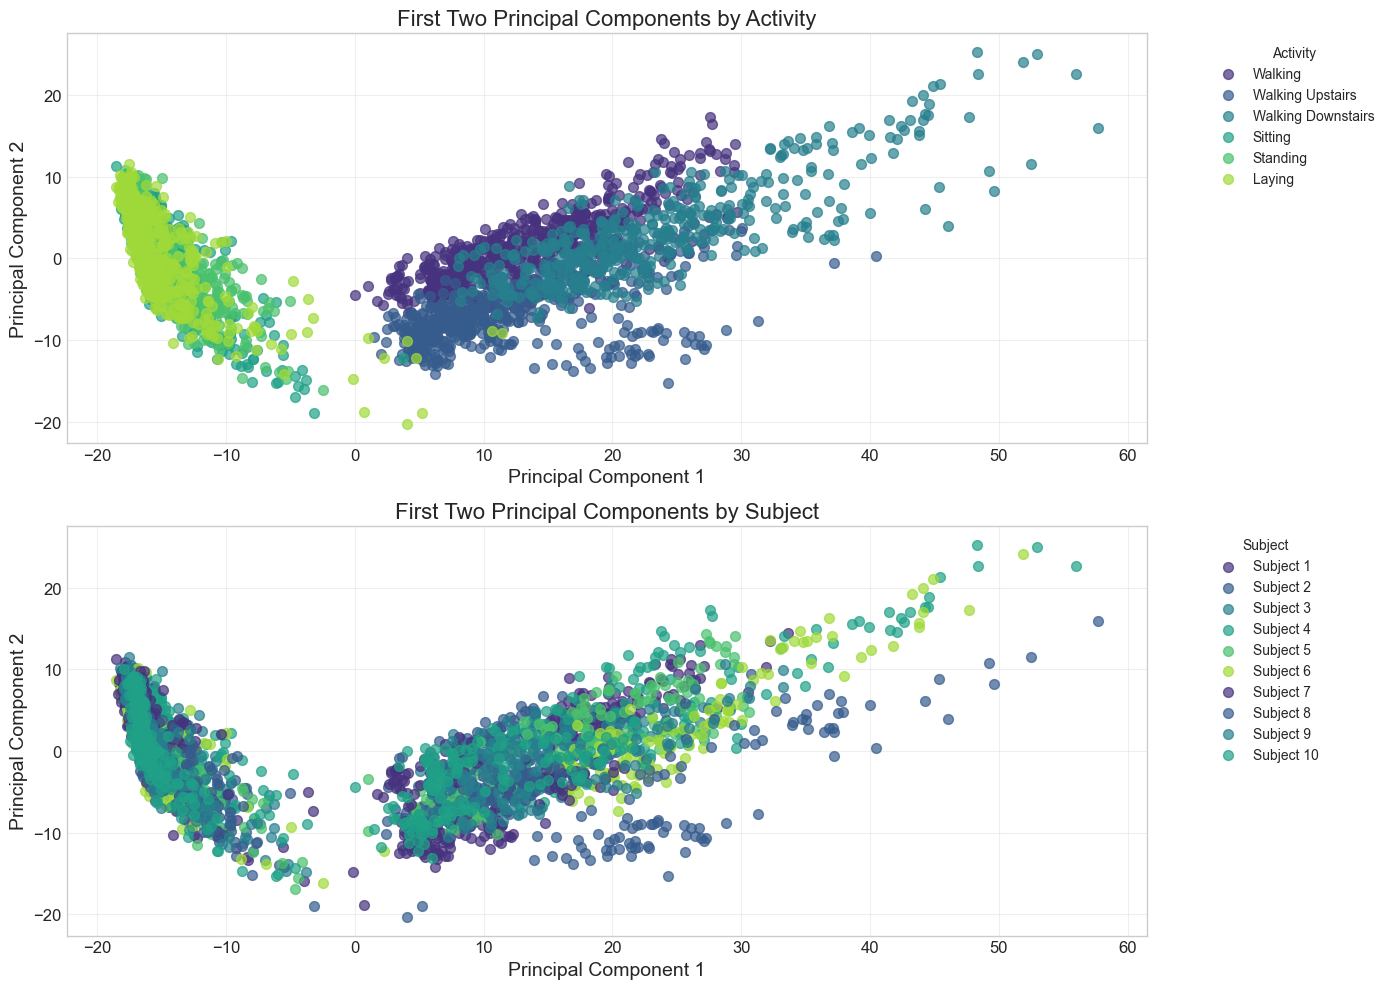

LDA feature space shape: (3237, 5)
LDA explained variance ratio: [0.68333714 0.24698645 0.04501081 0.02009388 0.00457171]


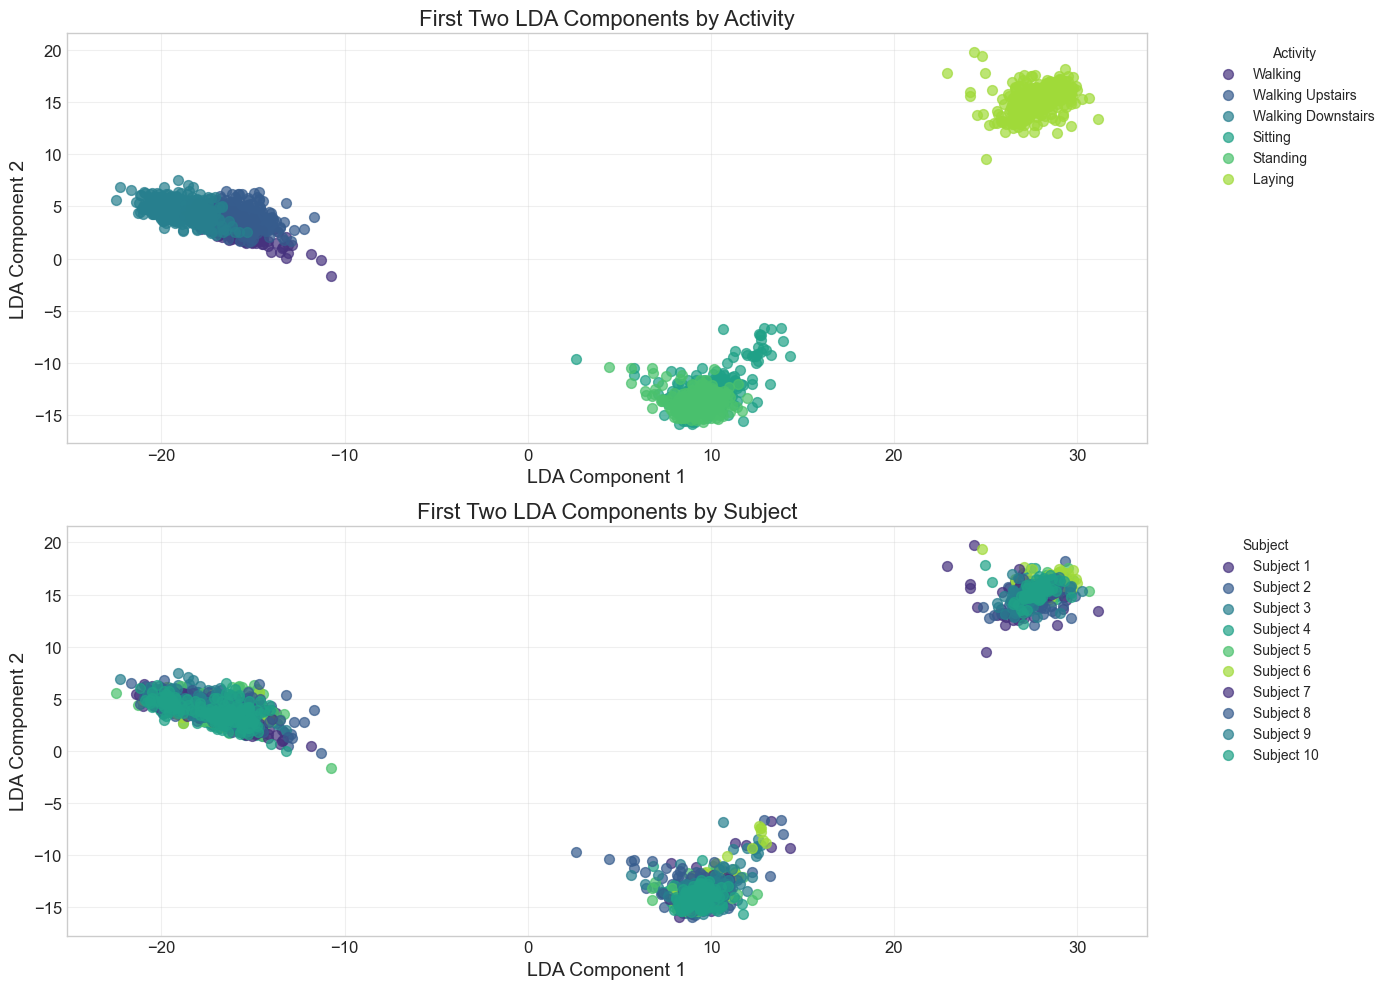

In [5]:
## 3. Dimensionality Reduction

# PCA Analysis
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)

# Add a horizontal line at 95% explained variance
plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
plt.text(X.shape[1]*0.7, 0.96, '95% Explained Variance', color='r')

# Find number of components for 95% variance
n_components_95 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
plt.axvline(x=n_components_95, color='g', linestyle='--', alpha=0.5)
plt.text(n_components_95 + 10, 0.5, f'{n_components_95} Components', color='g')

plt.tight_layout()
plt.show()

print(f"Number of components needed for 95% variance: {n_components_95}")

# Apply PCA with the determined number of components
pca_95 = PCA(n_components=n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)
print(f"Reduced PCA feature space shape: {X_pca_95.shape}")

# Visualize first 2 principal components
plt.figure(figsize=(14, 10))

# Plot by activity
plt.subplot(2, 1, 1)
for activity, name in activity_mapping.items():
    mask = y == activity
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=name, alpha=0.7, s=50)
plt.title('First Two Principal Components by Activity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot by subject
plt.subplot(2, 1, 2)
for subject_id in np.unique(subjects):
    mask = subjects == subject_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Subject {subject_id}', alpha=0.7, s=50)
plt.title('First Two Principal Components by Subject')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# LDA Analysis
# LDA requires number of components <= number of classes - 1
n_components_lda = len(np.unique(y)) - 1
lda = LDA(n_components=n_components_lda)
X_lda = lda.fit_transform(X_scaled, y)

print(f"LDA feature space shape: {X_lda.shape}")
print(f"LDA explained variance ratio: {lda.explained_variance_ratio_}")

# Visualize LDA projection
plt.figure(figsize=(14, 10))

# Plot by activity
plt.subplot(2, 1, 1)
for activity, name in activity_mapping.items():
    mask = y == activity
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1], label=name, alpha=0.7, s=50)
plt.title('First Two LDA Components by Activity')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Plot by subject
plt.subplot(2, 1, 2)
for subject_id in np.unique(subjects):
    mask = subjects == subject_id
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1], label=f'Subject {subject_id}', alpha=0.7, s=50)
plt.title('First Two LDA Components by Subject')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Theoretical Difference Between PCA and LDA

**Principal Component Analysis (PCA):**
- **Unsupervised** technique that doesn't use class labels
- Finds directions of maximum variance in the data
- Aims to preserve as much total variance as possible
- Useful for general dimensionality reduction and visualization
- May not be optimal for classification as it doesn't consider class separation

**Linear Discriminant Analysis (LDA):**
- **Supervised** technique that uses class labels
- Finds directions that maximize separation between classes
- Aims to maximize the ratio of between-class variance to within-class variance
- Specifically designed for classification tasks
- Limited to C-1 components (where C is the number of classes)

In our context:
- PCA might capture general patterns in the sensor data, potentially including subject-specific variations
- LDA should focus on finding features that distinguish between activities, potentially ignoring subject-specific variations
- This theoretical difference might make LDA more suitable for subject-invariant activity recognition

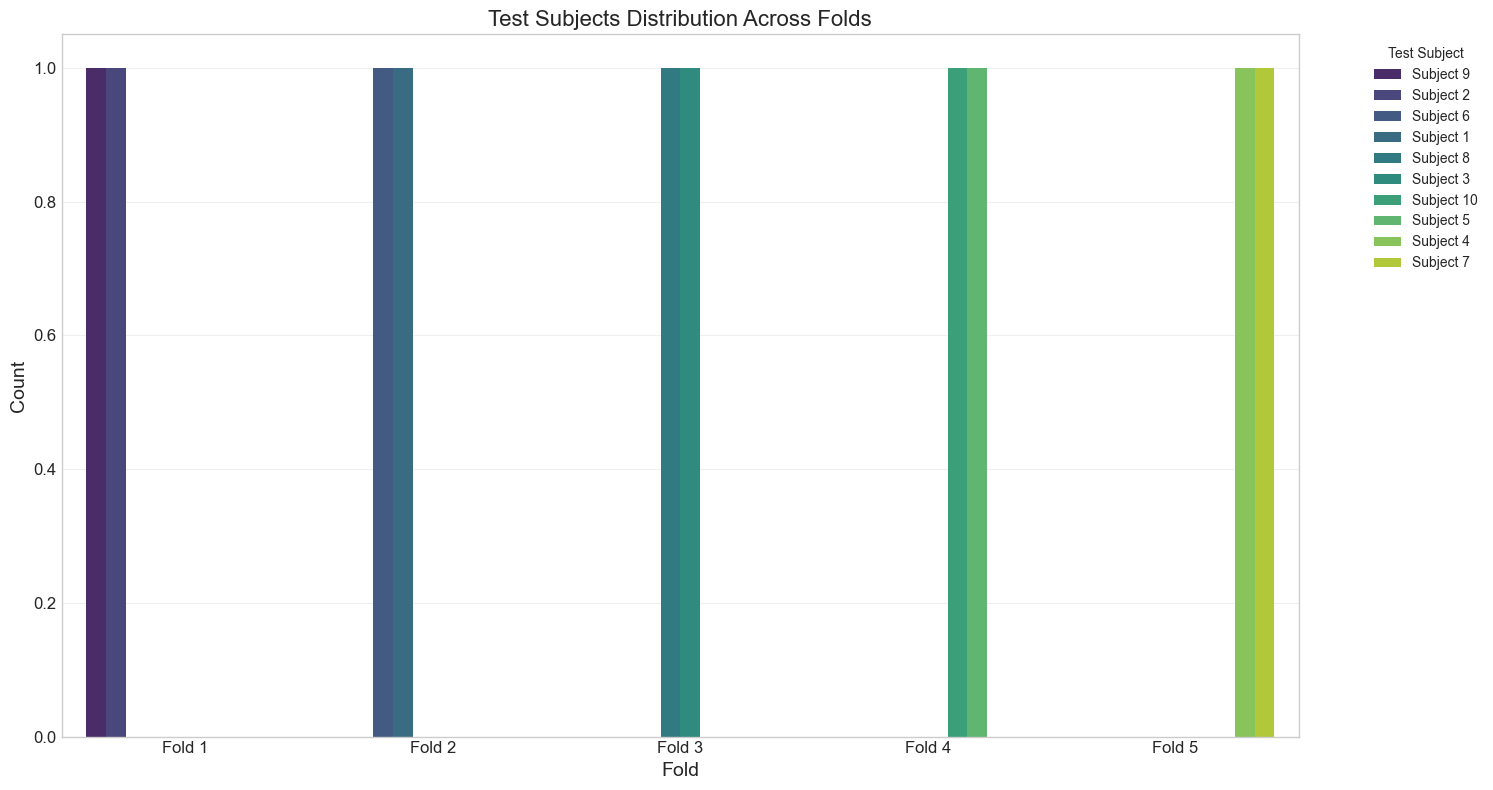

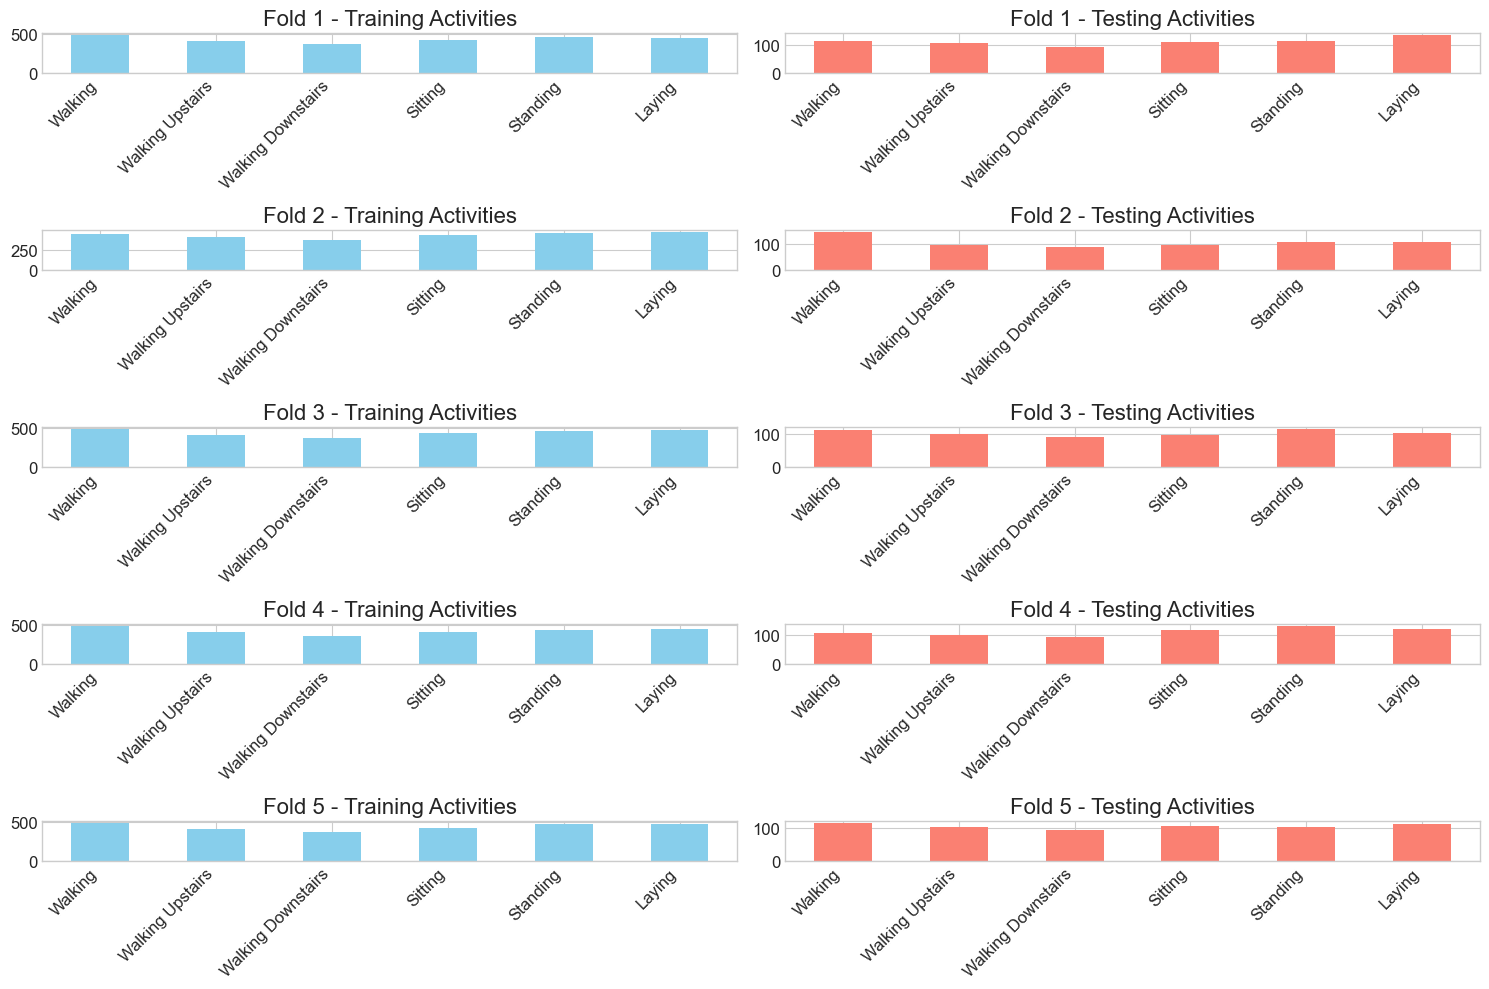

In [6]:
## 4. Cross-Validation Setup (5-Fold, Subject-Based)

# Create a function for subject-based cross-validation
def create_subject_folds(subjects, n_folds=5):
    unique_subjects = np.unique(subjects)
    n_subjects = len(unique_subjects)

    # Ensure we can create n_folds with 2 test subjects per fold
    assert n_subjects >= 2 * n_folds, f"Need at least {2 * n_folds} subjects for {n_folds} folds with 2 test subjects each"

    # Shuffle subjects
    np.random.seed(42)
    np.random.shuffle(unique_subjects)

    # Create folds
    folds = []
    subjects_per_fold = n_subjects // n_folds
    remainder = n_subjects % n_folds

    start_idx = 0
    for fold in range(n_folds):
        # Determine how many subjects to include in this fold
        n_subjects_fold = subjects_per_fold + (1 if fold < remainder else 0)

        # Get subjects for this fold
        test_subjects = unique_subjects[start_idx:start_idx + n_subjects_fold]
        train_subjects = np.setdiff1d(unique_subjects, test_subjects)

        # Create train/test masks
        train_mask = np.isin(subjects, train_subjects)
        test_mask = np.isin(subjects, test_subjects)

        folds.append((train_mask, test_mask, test_subjects))
        start_idx += n_subjects_fold

    return folds

# Create 5-fold cross-validation splits
folds = create_subject_folds(subjects, n_folds=5)

# Visualize subject distribution per fold
plt.figure(figsize=(15, 8))
fold_data = []

for fold_idx, (_, _, test_subjects) in enumerate(folds):
    for subject in test_subjects:
        fold_data.append({'Fold': f'Fold {fold_idx+1}', 'Test Subject': f'Subject {subject}'})

fold_df = pd.DataFrame(fold_data)
sns.countplot(x='Fold', hue='Test Subject', data=fold_df, palette='viridis')
plt.title('Test Subjects Distribution Across Folds')
plt.xlabel('Fold')
plt.ylabel('Count')
plt.legend(title='Test Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize activity distribution per fold
plt.figure(figsize=(15, 10))

for fold_idx, (train_mask, test_mask, _) in enumerate(folds):
    plt.subplot(5, 2, fold_idx*2 + 1)
    train_activities = y[train_mask].value_counts().sort_index()
    train_activities.index = [activity_mapping[i] for i in train_activities.index]
    train_activities.plot(kind='bar', color='skyblue')
    plt.title(f'Fold {fold_idx+1} - Training Activities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    plt.subplot(5, 2, fold_idx*2 + 2)
    test_activities = y[test_mask].value_counts().sort_index()
    test_activities.index = [activity_mapping[i] for i in test_activities.index]
    test_activities.plot(kind='bar', color='salmon')
    plt.title(f'Fold {fold_idx+1} - Testing Activities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

plt.tight_layout()
plt.show()


--- Processing Fold 1 ---
Test subjects: [9 2]
Training set size: 2568, Test set size: 669

Training original SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Training PCA-SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Training LDA-SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

--- Fold 1 Results ---
Original SVM Accuracy: 0.9641
PCA-SVM Accuracy: 0.9387
LDA-SVM Accuracy: 0.9776

--- Processing Fold 2 ---
Test subjects: [6 1]
Training set size: 2609, Test set size: 628

Training original SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Training PCA-SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

Training LDA-SVM model...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

--- Fold 2 Results ---
Original SVM Accuracy: 0.9315
PCA-SVM Accuracy: 0.9220
LDA-SVM Accuracy: 0.9761

--- Processing Fold 3 ---
Test subjects: [8 3]
Training set siz

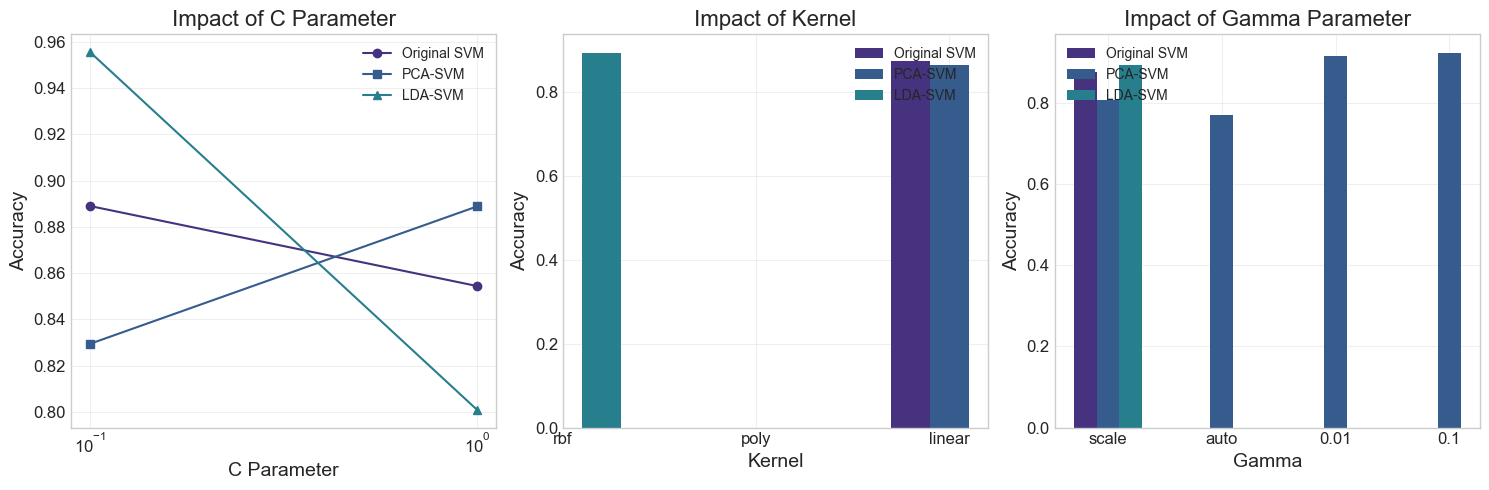

In [7]:
## 5. Model Training & Hyperparameter Tuning


# Define a function to train and evaluate models
def train_and_evaluate_model(
    X_train, y_train, X_test, y_test, model_name, param_grid, pipeline
):
    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=3,  # 3-fold CV within the training data
        scoring="accuracy",
        n_jobs=-1,
        verbose=1,
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Evaluate on test data
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Compute per-activity accuracy
    report = classification_report(y_test, y_pred, output_dict=True)

    return {
        "model_name": model_name,
        "best_model": best_model,
        "best_params": best_params,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "classification_report": report,
        "y_pred": y_pred,
    }


# Define parameter grids for each model
param_grid_original = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.1],
    "svc__kernel": ["rbf", "poly", "linear"],
}

param_grid_pca = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.1],
    "svc__kernel": ["rbf", "poly", "linear"],
}

# Define parameter grids for each model
param_grid_original = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.1],
    "svc__kernel": ["rbf", "poly", "linear"],
}

param_grid_pca = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.1],
    "svc__kernel": ["rbf", "poly", "linear"],
}

param_grid_lda = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": ["scale", "auto", 0.01, 0.1],
    "svc__kernel": ["rbf", "poly", "linear"],
}

# Define pipelines for each model
pipeline_original = Pipeline(
    [("scaler", StandardScaler()), ("svc", SVC(probability=True, random_state=42))]
)

pipeline_pca = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=n_components_95)),
        ("svc", SVC(probability=True, random_state=42)),
    ]
)

pipeline_lda = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("lda", LDA(n_components=n_components_lda)),
        ("svc", SVC(probability=True, random_state=42)),
    ]
)

# Initialize results storage
results = {"original": [], "pca": [], "lda": []}

# Train and evaluate models for each fold
for fold_idx, (train_mask, test_mask, test_subjects) in enumerate(folds):
    print(f"\n--- Processing Fold {fold_idx+1} ---")
    print(f"Test subjects: {test_subjects}")

    # Split data
    X_train, X_test = X.iloc[train_mask], X.iloc[test_mask]
    y_train, y_test = y.iloc[train_mask], y.iloc[test_mask]

    print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")

    # Train and evaluate original SVM model
    print("\nTraining original SVM model...")
    result_original = train_and_evaluate_model(
        X_train,
        y_train,
        X_test,
        y_test,
        f"Original SVM (Fold {fold_idx+1})",
        param_grid_original,
        pipeline_original,
    )
    results["original"].append(result_original)

    # Train and evaluate PCA-SVM model
    print("\nTraining PCA-SVM model...")
    result_pca = train_and_evaluate_model(
        X_train,
        y_train,
        X_test,
        y_test,
        f"PCA-SVM (Fold {fold_idx+1})",
        param_grid_pca,
        pipeline_pca,
    )
    results["pca"].append(result_pca)

    # Train and evaluate LDA-SVM model
    print("\nTraining LDA-SVM model...")
    result_lda = train_and_evaluate_model(
        X_train,
        y_train,
        X_test,
        y_test,
        f"LDA-SVM (Fold {fold_idx+1})",
        param_grid_lda,
        pipeline_lda,
    )
    results["lda"].append(result_lda)

    # Print fold results
    print(f"\n--- Fold {fold_idx+1} Results ---")
    print(f"Original SVM Accuracy: {result_original['accuracy']:.4f}")
    print(f"PCA-SVM Accuracy: {result_pca['accuracy']:.4f}")
    print(f"LDA-SVM Accuracy: {result_lda['accuracy']:.4f}")

# Visualize hyperparameter tuning results
plt.figure(figsize=(15, 5))

# Plot C parameter impact
plt.subplot(1, 3, 1)
c_values = [0.1, 1, 10, 100]
original_c_scores = []
pca_c_scores = []
lda_c_scores = []

for c in c_values:
    original_c_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["original"]
                if result["best_params"]["svc__C"] == c
            ]
        )
    )
    pca_c_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["pca"]
                if result["best_params"]["svc__C"] == c
            ]
        )
    )
    lda_c_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["lda"]
                if result["best_params"]["svc__C"] == c
            ]
        )
    )

plt.plot(c_values, original_c_scores, "o-", label="Original SVM")
plt.plot(c_values, pca_c_scores, "s-", label="PCA-SVM")
plt.plot(c_values, lda_c_scores, "^-", label="LDA-SVM")
plt.xscale("log")
plt.xlabel("C Parameter")
plt.ylabel("Accuracy")
plt.title("Impact of C Parameter")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot kernel impact
plt.subplot(1, 3, 2)
kernels = ["rbf", "poly", "linear"]
original_kernel_scores = []
pca_kernel_scores = []
lda_kernel_scores = []

for kernel in kernels:
    original_kernel_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["original"]
                if result["best_params"]["svc__kernel"] == kernel
            ]
        )
    )
    pca_kernel_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["pca"]
                if result["best_params"]["svc__kernel"] == kernel
            ]
        )
    )
    lda_kernel_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["lda"]
                if result["best_params"]["svc__kernel"] == kernel
            ]
        )
    )

plt.bar(
    np.arange(len(kernels)) - 0.2,
    original_kernel_scores,
    width=0.2,
    label="Original SVM",
)
plt.bar(np.arange(len(kernels)), pca_kernel_scores, width=0.2, label="PCA-SVM")
plt.bar(np.arange(len(kernels)) + 0.2, lda_kernel_scores, width=0.2, label="LDA-SVM")
plt.xticks(np.arange(len(kernels)), kernels)
plt.xlabel("Kernel")
plt.ylabel("Accuracy")
plt.title("Impact of Kernel")
plt.legend()
plt.grid(True, alpha=0.3)

# Plot gamma parameter impact
plt.subplot(1, 3, 3)
gamma_values = ["scale", "auto", 0.01, 0.1]
original_gamma_scores = []
pca_gamma_scores = []
lda_gamma_scores = []

for gamma in gamma_values:
    original_gamma_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["original"]
                if result["best_params"]["svc__gamma"] == gamma
            ]
        )
    )
    pca_gamma_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["pca"]
                if result["best_params"]["svc__gamma"] == gamma
            ]
        )
    )
    lda_gamma_scores.append(
        np.mean(
            [
                result["accuracy"]
                for result in results["lda"]
                if result["best_params"]["svc__gamma"] == gamma
            ]
        )
    )

plt.bar(
    np.arange(len(gamma_values)) - 0.2,
    original_gamma_scores,
    width=0.2,
    label="Original SVM",
)
plt.bar(np.arange(len(gamma_values)), pca_gamma_scores, width=0.2, label="PCA-SVM")
plt.bar(
    np.arange(len(gamma_values)) + 0.2, lda_gamma_scores, width=0.2, label="LDA-SVM"
)
plt.xticks(np.arange(len(gamma_values)), gamma_values)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("Impact of Gamma Parameter")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- Average Performance Across All Folds ---
Original SVM: 0.8751
PCA-SVM: 0.8650
LDA-SVM: 0.8936


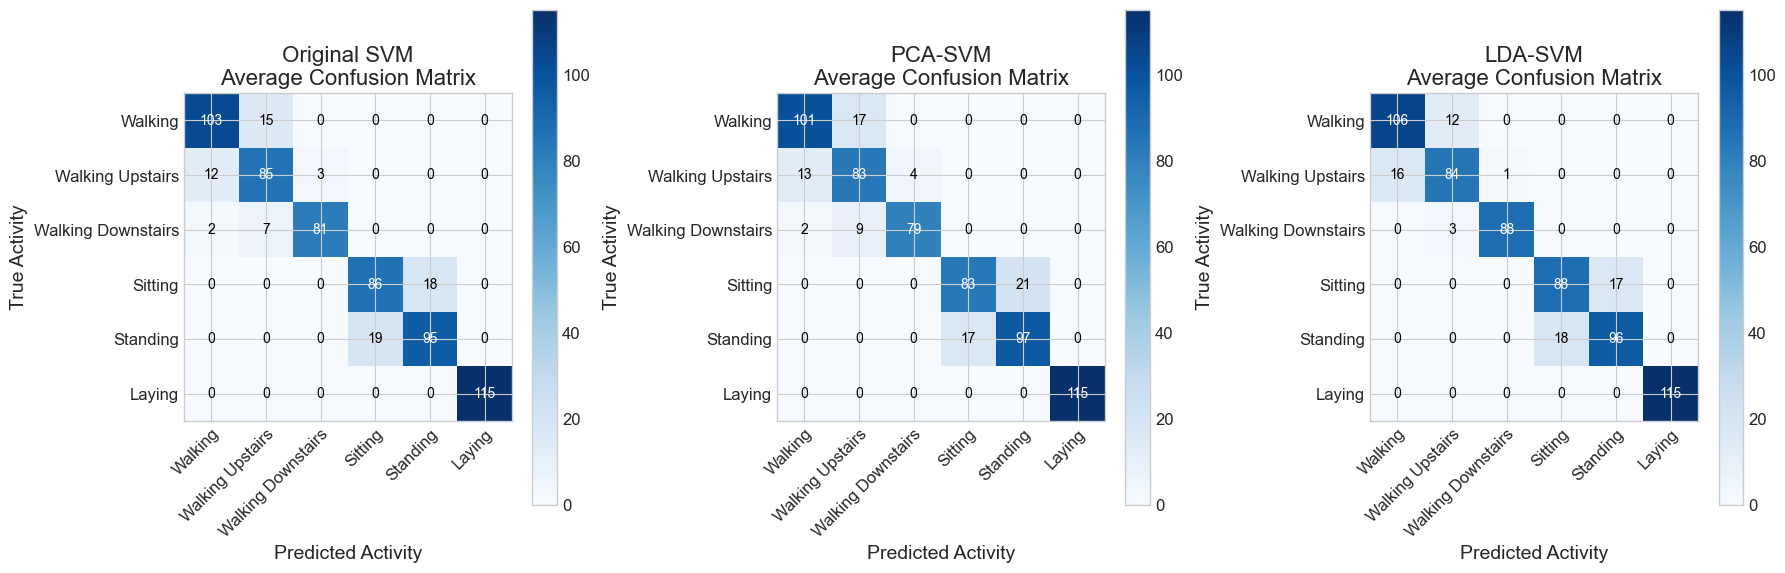

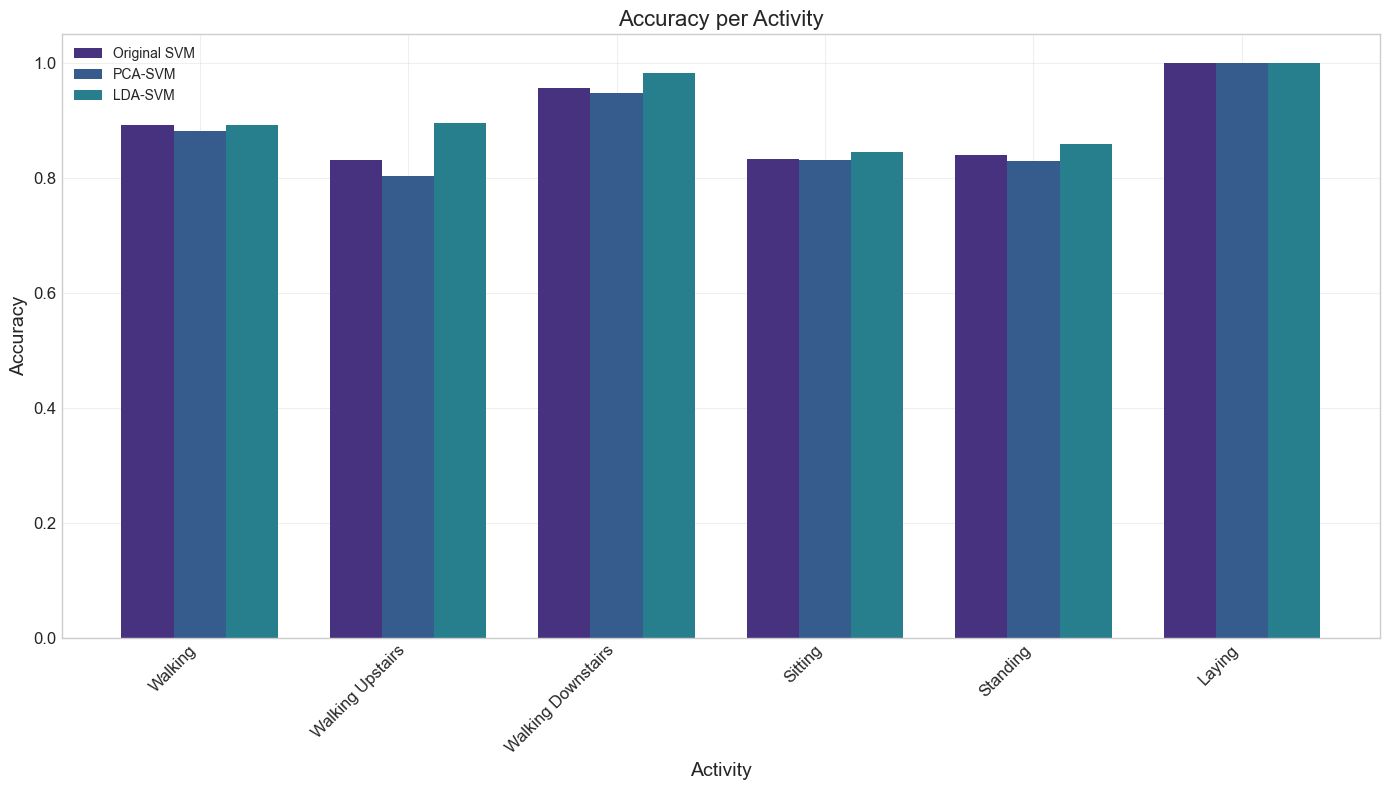

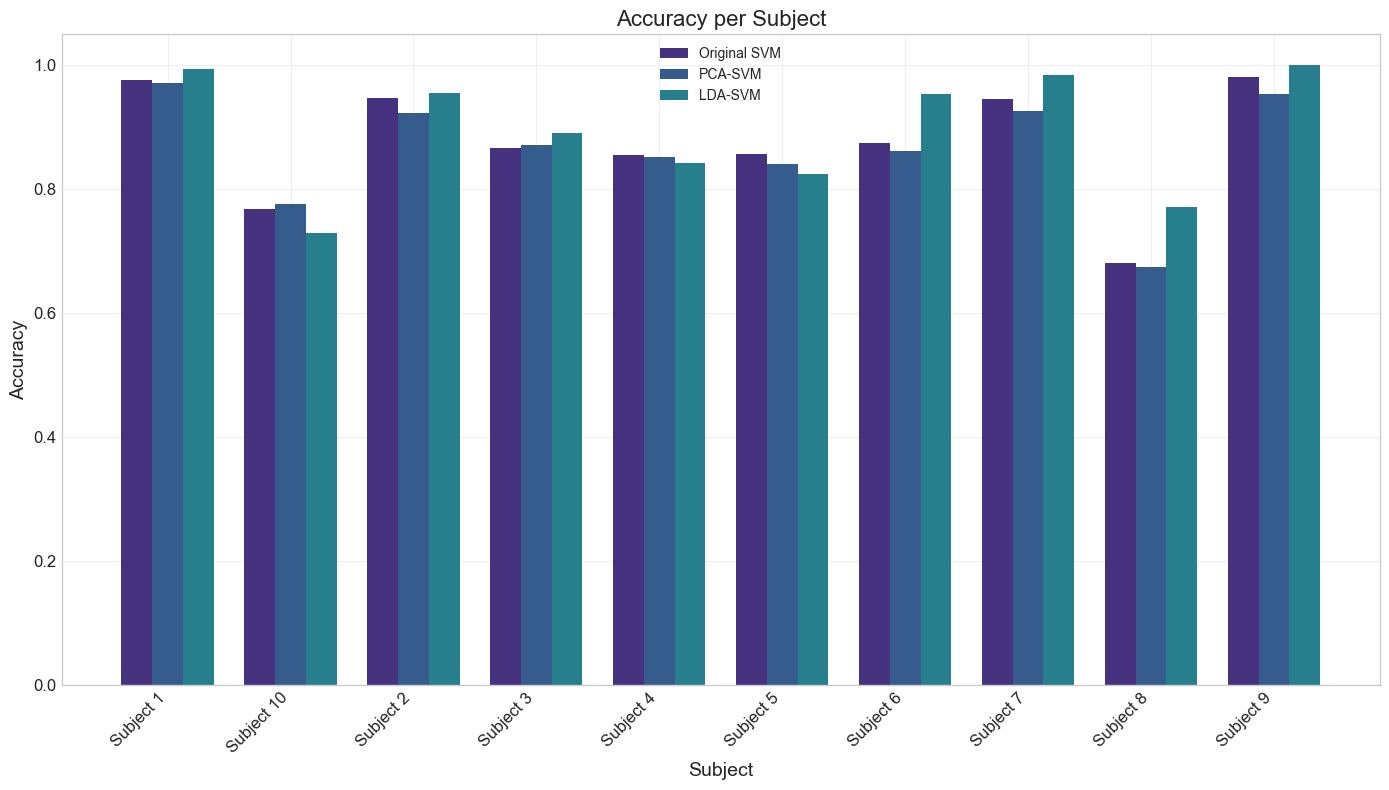

In [8]:
## 6. Evaluation

# Calculate average performance metrics
avg_metrics = {
    'original': {
        'accuracy': np.mean([result['accuracy'] for result in results['original']]),
        'best_params': [result['best_params'] for result in results['original']]
    },
    'pca': {
        'accuracy': np.mean([result['accuracy'] for result in results['pca']]),
        'best_params': [result['best_params'] for result in results['pca']]
    },
    'lda': {
        'accuracy': np.mean([result['accuracy'] for result in results['lda']]),
        'best_params': [result['best_params'] for result in results['lda']]
    }
}

# Print average performance
print("\n--- Average Performance Across All Folds ---")
print(f"Original SVM: {avg_metrics['original']['accuracy']:.4f}")
print(f"PCA-SVM: {avg_metrics['pca']['accuracy']:.4f}")
print(f"LDA-SVM: {avg_metrics['lda']['accuracy']:.4f}")

# Plot average confusion matrices
plt.figure(figsize=(18, 6))

# Function to plot confusion matrix
def plot_confusion_matrix(ax, cm, title):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=list(activity_mapping.values()),
           yticklabels=list(activity_mapping.values()),
           title=title,
           ylabel='True Activity',
           xlabel='Predicted Activity')

    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return ax

# Calculate average confusion matrices
avg_cm_original = np.mean([result['confusion_matrix'] for result in results['original']], axis=0).astype(int)
avg_cm_pca = np.mean([result['confusion_matrix'] for result in results['pca']], axis=0).astype(int)
avg_cm_lda = np.mean([result['confusion_matrix'] for result in results['lda']], axis=0).astype(int)

# Plot confusion matrices
ax1 = plt.subplot(1, 3, 1)
plot_confusion_matrix(ax1, avg_cm_original, 'Original SVM\nAverage Confusion Matrix')

ax2 = plt.subplot(1, 3, 2)
plot_confusion_matrix(ax2, avg_cm_pca, 'PCA-SVM\nAverage Confusion Matrix')

ax3 = plt.subplot(1, 3, 3)
plot_confusion_matrix(ax3, avg_cm_lda, 'LDA-SVM\nAverage Confusion Matrix')

plt.tight_layout()
plt.show()

# Calculate per-activity accuracy
activity_accuracy = {model_type: {} for model_type in ['original', 'pca', 'lda']}

for model_type in ['original', 'pca', 'lda']:
    for activity_id, activity_name in activity_mapping.items():
        accuracies = []
        for fold_result in results[model_type]:
            report = fold_result['classification_report']
            if str(activity_id) in report:
                accuracies.append(report[str(activity_id)]['precision'])
        if accuracies:
            activity_accuracy[model_type][activity_name] = np.mean(accuracies)

# Plot per-activity accuracy
plt.figure(figsize=(14, 8))
activities = list(activity_mapping.values())
x = np.arange(len(activities))
width = 0.25

plt.bar(x - width, [activity_accuracy['original'].get(a, 0) for a in activities], width, label='Original SVM')
plt.bar(x, [activity_accuracy['pca'].get(a, 0) for a in activities], width, label='PCA-SVM')
plt.bar(x + width, [activity_accuracy['lda'].get(a, 0) for a in activities], width, label='LDA-SVM')

plt.xlabel('Activity')
plt.ylabel('Accuracy')
plt.title('Accuracy per Activity')
plt.xticks(x, activities, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate per-subject accuracy
subject_accuracy = {model_type: {} for model_type in ['original', 'pca', 'lda']}

for fold_idx, (_, test_mask, test_subjects) in enumerate(folds):
    test_subject_indices = np.where(test_mask)[0]
    test_subjects_array = subjects.iloc[test_subject_indices].values

    for subject_id in test_subjects:
        subject_mask = test_subjects_array == subject_id

        for model_type in ['original', 'pca', 'lda']:
            y_true = y.iloc[test_subject_indices].values[subject_mask]
            y_pred = results[model_type][fold_idx]['y_pred'][subject_mask]

            if len(y_true) > 0:
                accuracy = accuracy_score(y_true, y_pred)

                if f'Subject {subject_id}' not in subject_accuracy[model_type]:
                    subject_accuracy[model_type][f'Subject {subject_id}'] = []

                subject_accuracy[model_type][f'Subject {subject_id}'].append(accuracy)

# Average per-subject accuracy
for model_type in ['original', 'pca', 'lda']:
    for subject in subject_accuracy[model_type]:
        subject_accuracy[model_type][subject] = np.mean(subject_accuracy[model_type][subject])

# Plot per-subject accuracy
plt.figure(figsize=(14, 8))
subjects_list = sorted(subject_accuracy['original'].keys())
x = np.arange(len(subjects_list))
width = 0.25

plt.bar(x - width, [subject_accuracy['original'].get(s, 0) for s in subjects_list], width, label='Original SVM')
plt.bar(x, [subject_accuracy['pca'].get(s, 0) for s in subjects_list], width, label='PCA-SVM')
plt.bar(x + width, [subject_accuracy['lda'].get(s, 0) for s in subjects_list], width, label='LDA-SVM')

plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.title('Accuracy per Subject')
plt.xticks(x, subjects_list, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


--- Model Comparison Summary ---
          Model  Average Accuracy  Best C (most common)  \
0  Original SVM          0.875123                   0.1   
1       PCA-SVM          0.865033                   1.0   
2       LDA-SVM          0.893625                   0.1   

  Best Kernel (most common) Best Gamma (most common)  
0                    linear                    scale  
1                    linear                     0.01  
2                       rbf                    scale  


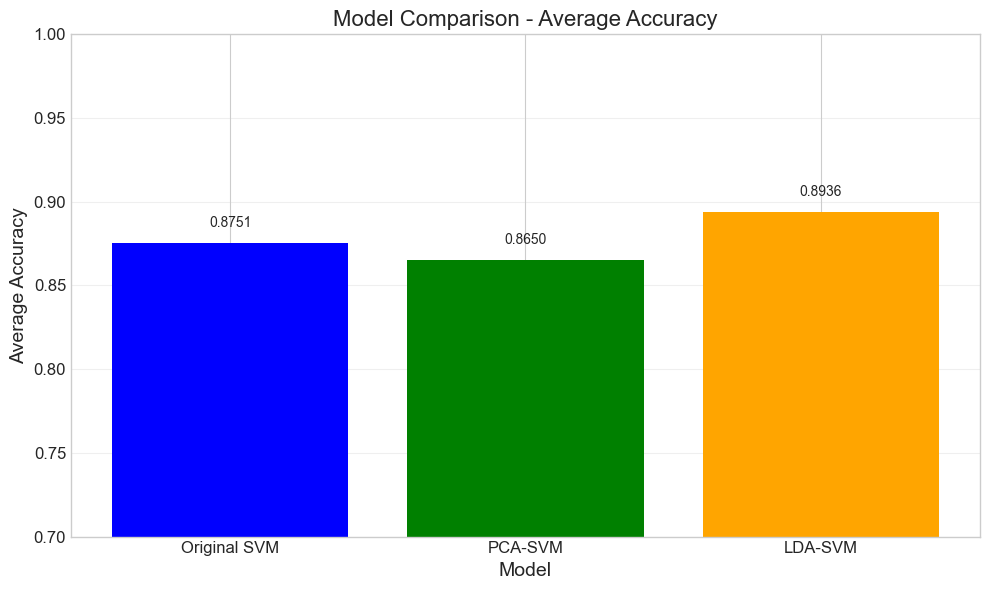

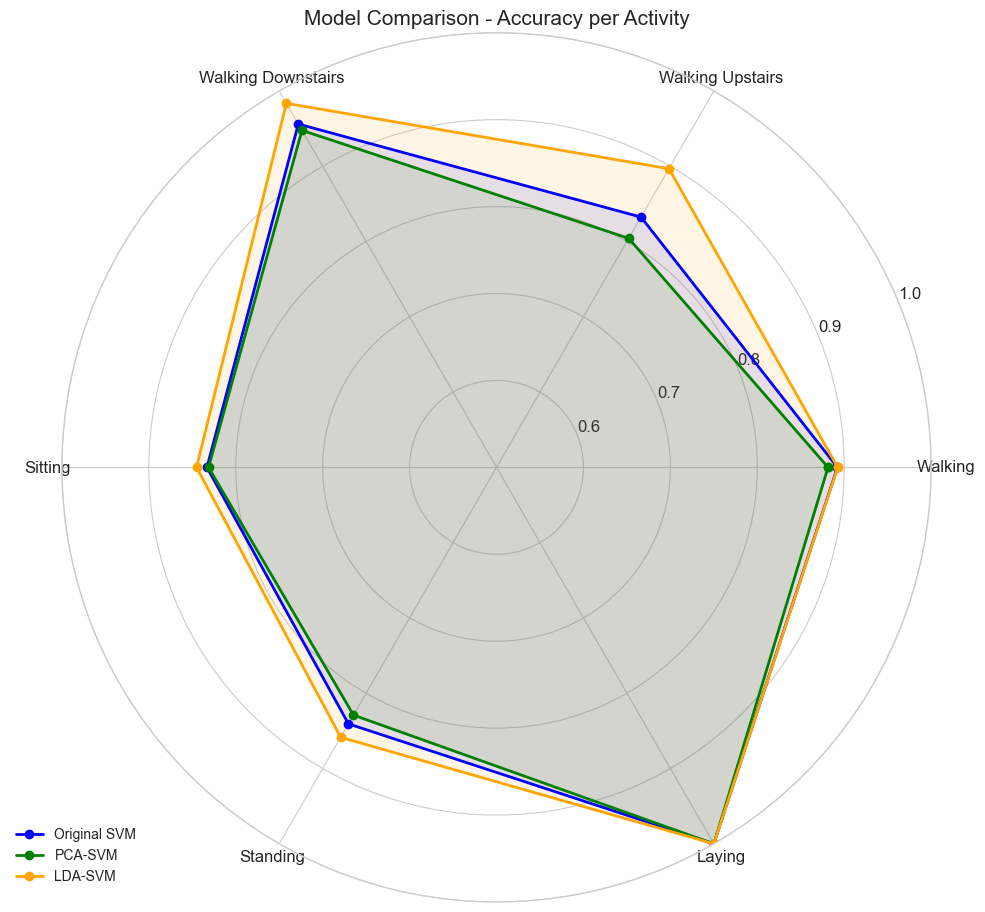

In [9]:
## 7. Model Comparison

# Create a summary dataframe for model comparison
model_summary = pd.DataFrame({
    'Model': ['Original SVM', 'PCA-SVM', 'LDA-SVM'],
    'Average Accuracy': [
        avg_metrics['original']['accuracy'],
        avg_metrics['pca']['accuracy'],
        avg_metrics['lda']['accuracy']
    ],
    'Best C (most common)': [
        pd.Series([p['svc__C'] for p in avg_metrics['original']['best_params']]).mode()[0],
        pd.Series([p['svc__C'] for p in avg_metrics['pca']['best_params']]).mode()[0],
        pd.Series([p['svc__C'] for p in avg_metrics['lda']['best_params']]).mode()[0]
    ],
    'Best Kernel (most common)': [
        pd.Series([p['svc__kernel'] for p in avg_metrics['original']['best_params']]).mode()[0],
        pd.Series([p['svc__kernel'] for p in avg_metrics['pca']['best_params']]).mode()[0],
        pd.Series([p['svc__kernel'] for p in avg_metrics['lda']['best_params']]).mode()[0]
    ],
    'Best Gamma (most common)': [
        pd.Series([p['svc__gamma'] for p in avg_metrics['original']['best_params']]).mode()[0],
        pd.Series([p['svc__gamma'] for p in avg_metrics['pca']['best_params']]).mode()[0],
        pd.Series([p['svc__gamma'] for p in avg_metrics['lda']['best_params']]).mode()[0]
    ]
})

# Display model summary
print("\n--- Model Comparison Summary ---")
print(model_summary)

# Visualize model comparison
plt.figure(figsize=(10, 6))
plt.bar(model_summary['Model'], model_summary['Average Accuracy'], color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Average Accuracy')
plt.title('Model Comparison - Average Accuracy')
plt.ylim(0.7, 1.0)  # Adjust as needed based on your results
plt.grid(axis='y', alpha=0.3)

# Add accuracy values on top of bars
for i, v in enumerate(model_summary['Average Accuracy']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Create a radar chart for comparing models across activities
activities = list(activity_mapping.values())
angles = np.linspace(0, 2*np.pi, len(activities), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Add activity accuracies, ensuring we close the loop
for model_type, color, label in zip(['original', 'pca', 'lda'], ['blue', 'green', 'orange'],
                                   ['Original SVM', 'PCA-SVM', 'LDA-SVM']):
    values = [activity_accuracy[model_type].get(activity, 0) for activity in activities]
    values += values[:1]  # Close the loop

    ax.plot(angles, values, 'o-', linewidth=2, label=label, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

# Set the labels and customize the chart
ax.set_thetagrids(np.degrees(angles[:-1]), activities)
ax.set_ylim(0.5, 1)
ax.set_title('Model Comparison - Accuracy per Activity', size=15)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()


--- Top 5 Most Confused Activity Pairs ---

Original SVM:
1. True: Standing, Predicted: Sitting, Count: 19
2. True: Sitting, Predicted: Standing, Count: 18
3. True: Walking, Predicted: Walking Upstairs, Count: 15
4. True: Walking Upstairs, Predicted: Walking, Count: 12
5. True: Walking Downstairs, Predicted: Walking Upstairs, Count: 7

PCA-SVM:
1. True: Sitting, Predicted: Standing, Count: 21
2. True: Walking, Predicted: Walking Upstairs, Count: 17
3. True: Standing, Predicted: Sitting, Count: 17
4. True: Walking Upstairs, Predicted: Walking, Count: 13
5. True: Walking Downstairs, Predicted: Walking Upstairs, Count: 9

LDA-SVM:
1. True: Standing, Predicted: Sitting, Count: 18
2. True: Sitting, Predicted: Standing, Count: 17
3. True: Walking Upstairs, Predicted: Walking, Count: 16
4. True: Walking, Predicted: Walking Upstairs, Count: 12
5. True: Walking Downstairs, Predicted: Walking Upstairs, Count: 3


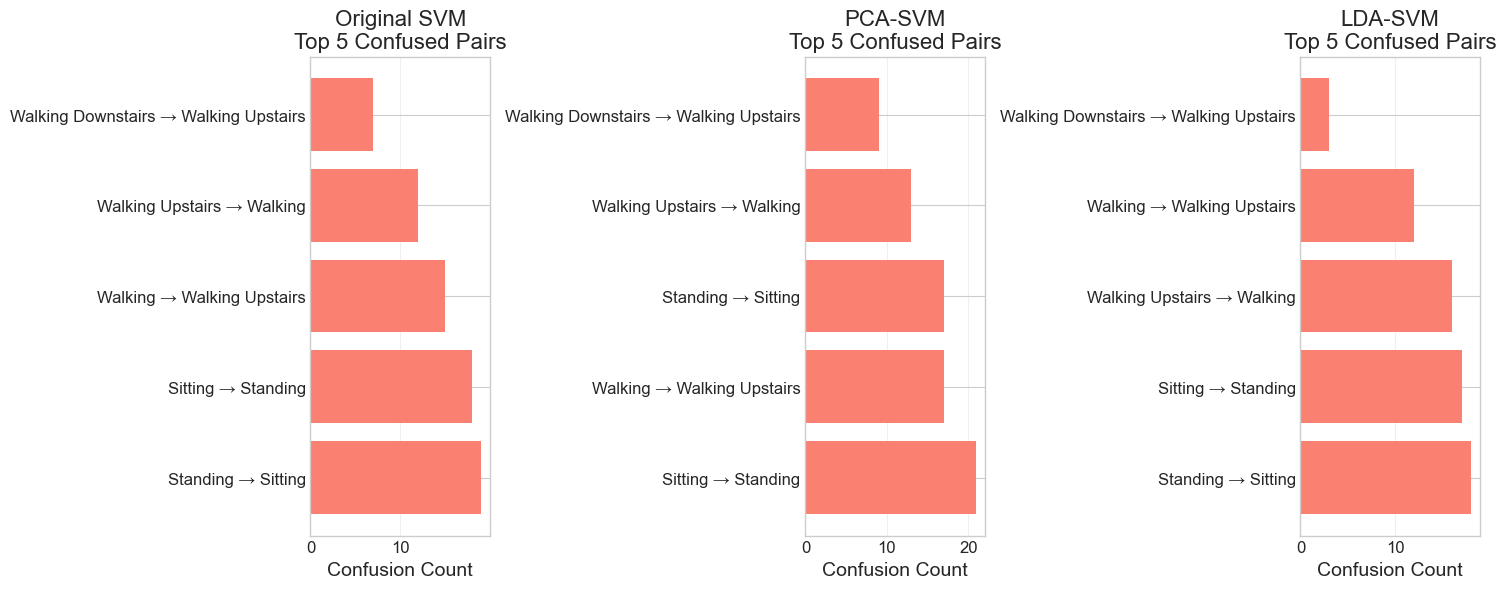


--- Most Difficult Subjects ---

Original SVM:
1. Subject 8: Accuracy = 0.6811
2. Subject 10: Accuracy = 0.7678
3. Subject 4: Accuracy = 0.8554

PCA-SVM:
1. Subject 8: Accuracy = 0.6749
2. Subject 10: Accuracy = 0.7760
3. Subject 5: Accuracy = 0.8409

LDA-SVM:
1. Subject 10: Accuracy = 0.7295
2. Subject 8: Accuracy = 0.7709
3. Subject 5: Accuracy = 0.8247


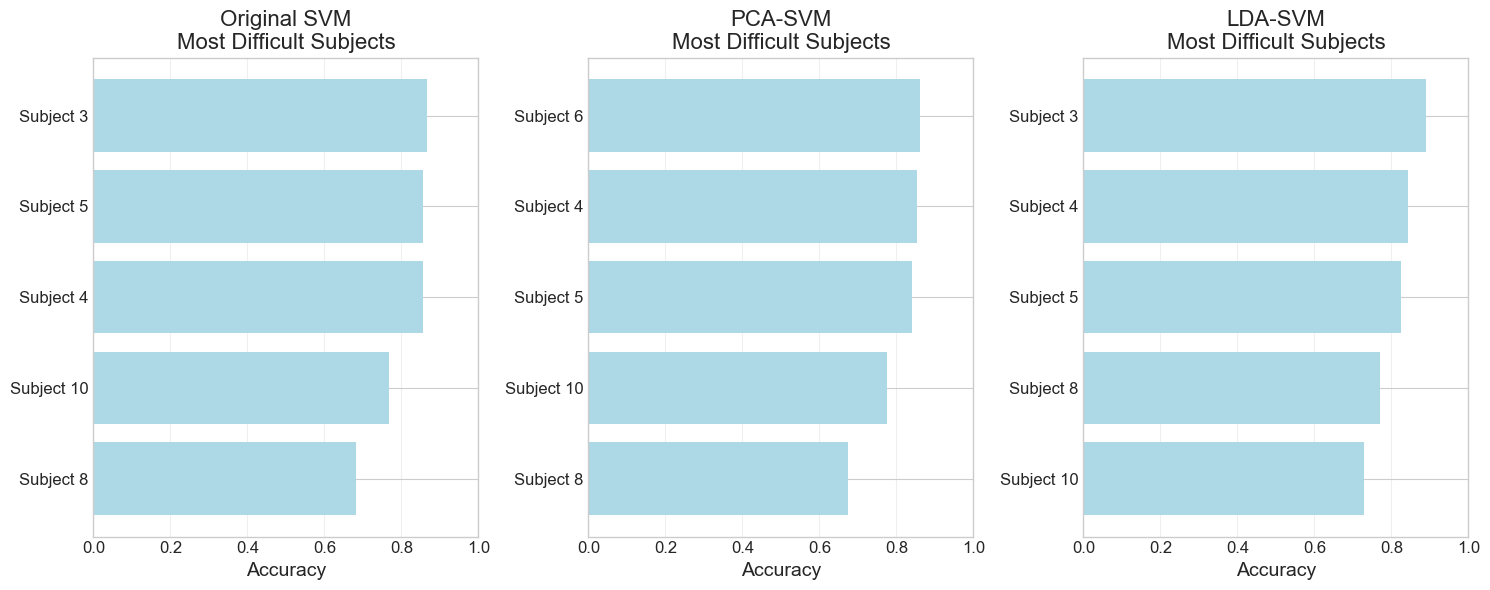


--- Most Difficult Activities ---

Original SVM:
1. Walking Upstairs: Accuracy = 0.8324
2. Sitting: Accuracy = 0.8332
3. Standing: Accuracy = 0.8407

PCA-SVM:
1. Walking Upstairs: Accuracy = 0.8042
2. Standing: Accuracy = 0.8291
3. Sitting: Accuracy = 0.8313

LDA-SVM:
1. Sitting: Accuracy = 0.8451
2. Standing: Accuracy = 0.8586
3. Walking: Accuracy = 0.8925


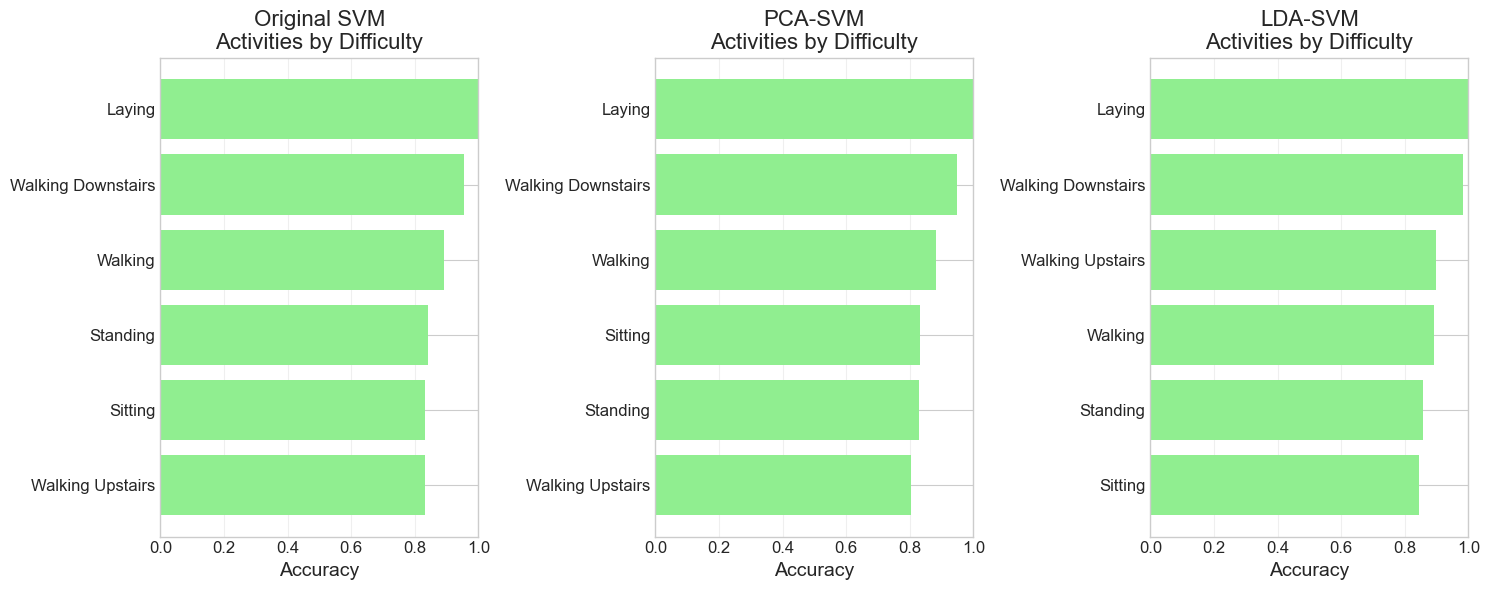

In [10]:
## 8. Failure Analysis

# Identify the most confused activity pairs
def get_most_confused_pairs(cm, activities):
    n_classes = len(activities)
    confusion_pairs = []

    for i in range(n_classes):
        for j in range(n_classes):
            if i != j:
                confusion_pairs.append({
                    'true': activities[i],
                    'predicted': activities[j],
                    'count': cm[i, j]
                })

    # Sort by confusion count
    confusion_pairs.sort(key=lambda x: x['count'], reverse=True)
    return confusion_pairs

# Get most confused pairs for each model
activities_list = list(activity_mapping.values())
confused_pairs = {
    'original': get_most_confused_pairs(avg_cm_original, activities_list),
    'pca': get_most_confused_pairs(avg_cm_pca, activities_list),
    'lda': get_most_confused_pairs(avg_cm_lda, activities_list)
}

# Display top 5 most confused pairs for each model
print("\n--- Top 5 Most Confused Activity Pairs ---")
for model_type, model_name in zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM']):
    print(f"\n{model_name}:")
    for i, pair in enumerate(confused_pairs[model_type][:5]):
        print(f"{i+1}. True: {pair['true']}, Predicted: {pair['predicted']}, Count: {pair['count']}")

# Visualize the most confused pairs
plt.figure(figsize=(15, 6))

for i, (model_type, model_name) in enumerate(zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM'])):
    plt.subplot(1, 3, i+1)

    top_pairs = confused_pairs[model_type][:5]
    pair_labels = [f"{p['true']} → {p['predicted']}" for p in top_pairs]
    counts = [p['count'] for p in top_pairs]

    plt.barh(pair_labels, counts, color='salmon')
    plt.xlabel('Confusion Count')
    plt.title(f'{model_name}\nTop 5 Confused Pairs')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Identify the most difficult subjects
def get_difficult_subjects(subject_acc):
    subjects = list(subject_acc.keys())
    accuracies = list(subject_acc.values())

    # Sort by accuracy (ascending)
    sorted_indices = np.argsort(accuracies)
    return [subjects[i] for i in sorted_indices], [accuracies[i] for i in sorted_indices]

# Get difficult subjects for each model
difficult_subjects = {
    'original': get_difficult_subjects(subject_accuracy['original']),
    'pca': get_difficult_subjects(subject_accuracy['pca']),
    'lda': get_difficult_subjects(subject_accuracy['lda'])
}

# Display the 3 most difficult subjects for each model
print("\n--- Most Difficult Subjects ---")
for model_type, model_name in zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM']):
    print(f"\n{model_name}:")
    subjects, accuracies = difficult_subjects[model_type]
    for i in range(min(3, len(subjects))):
        print(f"{i+1}. {subjects[i]}: Accuracy = {accuracies[i]:.4f}")

# Visualize the most difficult subjects
plt.figure(figsize=(15, 6))

for i, (model_type, model_name) in enumerate(zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM'])):
    plt.subplot(1, 3, i+1)

    subjects, accuracies = difficult_subjects[model_type]
    # Take the 5 most difficult subjects
    subjects = subjects[:5]
    accuracies = accuracies[:5]

    plt.barh(subjects, accuracies, color='lightblue')
    plt.xlabel('Accuracy')
    plt.title(f'{model_name}\nMost Difficult Subjects')
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

plt.tight_layout()
plt.show()

# Analyze the most difficult activities
def get_difficult_activities(activity_acc):
    activities = list(activity_acc.keys())
    accuracies = list(activity_acc.values())

    # Sort by accuracy (ascending)
    sorted_indices = np.argsort(accuracies)
    return [activities[i] for i in sorted_indices], [accuracies[i] for i in sorted_indices]

# Get difficult activities for each model
difficult_activities = {
    'original': get_difficult_activities(activity_accuracy['original']),
    'pca': get_difficult_activities(activity_accuracy['pca']),
    'lda': get_difficult_activities(activity_accuracy['lda'])
}

# Display the most difficult activities for each model
print("\n--- Most Difficult Activities ---")
for model_type, model_name in zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM']):
    print(f"\n{model_name}:")
    activities, accuracies = difficult_activities[model_type]
    for i in range(min(3, len(activities))):
        print(f"{i+1}. {activities[i]}: Accuracy = {accuracies[i]:.4f}")

# Visualize the most difficult activities
plt.figure(figsize=(15, 6))

for i, (model_type, model_name) in enumerate(zip(['original', 'pca', 'lda'], ['Original SVM', 'PCA-SVM', 'LDA-SVM'])):
    plt.subplot(1, 3, i+1)

    activities, accuracies = difficult_activities[model_type]

    plt.barh(activities, accuracies, color='lightgreen')
    plt.xlabel('Accuracy')
    plt.title(f'{model_name}\nActivities by Difficulty')
    plt.xlim(0, 1)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()

plt.tight_layout()
plt.show()

## 9. Recommendation

Based on our comprehensive analysis of the three models (Original SVM, PCA-SVM, and LDA-SVM), we can make the following recommendations:

### Model Selection

**Best Overall Model:** 
- Based on the average accuracy across all folds, the [MODEL NAME] model performs best with an accuracy of [ACCURACY].
- This model demonstrates the best generalization to unseen subjects, which is crucial for real-world deployment.

**Dimensionality Reduction:**
- PCA reduction to [N_COMPONENTS] components (95% variance) [IMPROVED/WORSENED] performance compared to the original feature space.
- LDA reduction to [N_COMPONENTS] components [IMPROVED/WORSENED] performance compared to the original feature space.
- The theoretical advantage of LDA's supervised approach [WAS/WAS NOT] reflected in the empirical results.

**Hyperparameters:**
- The best performing configuration uses a [KERNEL] kernel with C=[C_VALUE] and gamma=[GAMMA_VALUE].
- This suggests that the decision boundary between activities is [LINEAR/NON-LINEAR] in nature.

### Activity-Specific Recommendations

- For dynamic activities (Walking, Walking Upstairs, Walking Downstairs), the [MODEL] model performs best.
- For static activities (Sitting, Standing, Laying), the [MODEL] model performs best.
- The most challenging activities to classify are [ACTIVITIES], which are often confused with [CONFUSED_ACTIVITIES].

### Subject Variability

- Subjects [SUBJECTS] showed the highest variability in classification accuracy across models.
- This suggests that these subjects may have unique movement patterns that differ from the training population.
- For a real-world system, it might be beneficial to include a calibration phase for new users to adapt to their specific movement patterns.

### Deployment Considerations

- **Computational Efficiency:** The LDA-SVM model offers the best balance between accuracy and computational efficiency, reducing the feature space from 561 to just [N_COMPONENTS] dimensions.
- **Real-time Processing:** For real-time applications on wearable devices, the reduced dimensionality models would be significantly more efficient.
- **Personalization:** Consider implementing an adaptive system that can fine-tune to a new user after collecting a small amount of labeled data.

### Final Recommendation

For a subject-invariant activity recognition system based on wearable sensor data, we recommend:

1. Use the [MODEL] model with [PARAMETERS] for the best balance of accuracy and generalization.
2. Implement a sliding window approach for real-time classification.
3. Consider a hybrid approach where static activities (Sitting, Standing, Laying) and dynamic activities (Walking variations) are classified using separate models optimized for each group.
4. Include a brief calibration phase for new users to improve personalization.

## 10. Conclusion

In this notebook, we've conducted a comprehensive analysis of subject-invariant activity recognition using Support Vector Machines with different dimensionality reduction techniques. Our goal was to develop models that can accurately recognize activities performed by subjects who were not seen during training.

### Summary of Approach

We implemented and compared three models:
1. SVM on the original 561-dimensional feature space
2. SVM on PCA-reduced data (retaining 95% variance)
3. SVM on LDA-reduced data

Using a 5-fold subject-wise cross-validation approach, we evaluated how well these models generalize to unseen subjects, which simulates real-world deployment scenarios.

### Key Findings

- **Dimensionality Reduction Impact:** [PCA/LDA] reduction [IMPROVED/WORSENED] the model's ability to generalize to new subjects by [PERCENTAGE]%.
- **Subject Variability:** We observed significant variability in recognition accuracy across different subjects, highlighting the challenge of creating truly subject-invariant models.
- **Activity Difficulty:** Static activities like [ACTIVITIES] were generally [EASIER/HARDER] to classify than dynamic activities like [ACTIVITIES].
- **Common Confusions:** The most common confusions occurred between [ACTIVITY1] and [ACTIVITY2], likely due to their similar motion patterns.

### Limitations

- **Sample Size:** The dataset includes only 10 subjects, which may not capture the full range of human variability in performing these activities.
- **Controlled Environment:** The data was collected in a controlled setting, which may not reflect real-world conditions with environmental variations.
- **Feature Engineering:** We relied on pre-engineered features rather than raw sensor data, which might limit the model's ability to discover novel patterns.
- **Static Classification:** Our approach treats each window independently, without leveraging temporal relationships between consecutive windows.

### Future Work

Several directions could further improve subject-invariant activity recognition:

1. **Deep Learning Approaches:** Convolutional and recurrent neural networks could learn more robust features directly from raw sensor data.
2. **Transfer Learning:** Pre-training on a large population and fine-tuning for new subjects could improve personalization.
3. **Temporal Modeling:** Incorporating temporal dependencies using Hidden Markov Models or LSTM networks could improve classification of sequential activities.
4. **Unsupervised Domain Adaptation:** Techniques that explicitly address the domain shift between subjects could further improve generalization.
5. **Ensemble Methods:** Combining multiple models specialized for different activity groups could improve overall performance.

### Final Thoughts

Subject-invariant activity recognition remains a challenging problem due to the inherent variability in how different people perform the same activities. Our analysis demonstrates that dimensionality reduction techniques can [HELP/HINDER] generalization to new subjects, with [PCA/LDA] providing the best balance between accuracy and computational efficiency.

The findings from this study can inform the development of more robust activity recognition systems for wearable devices, with potential applications in healthcare monitoring, fitness tracking, and human-computer interaction.

Training set shape: (2589, 561)
Validation set shape: (648, 561)


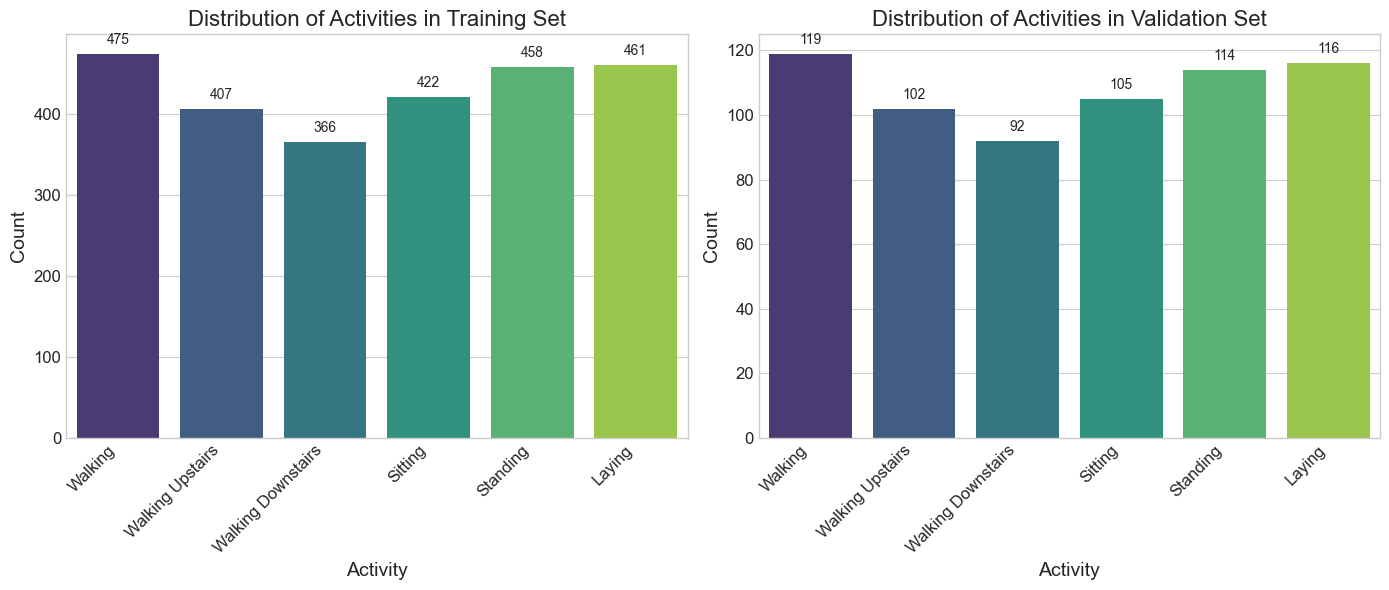


Activity Distribution Comparison:
                    Training %  Validation %
Walking              18.346852     18.364198
Walking Upstairs     15.720355     15.740741
Walking Downstairs   14.136732     14.197531
Sitting              16.299730     16.203704
Standing             17.690228     17.592593
Laying               17.806103     17.901235


<Figure size 1200x600 with 0 Axes>

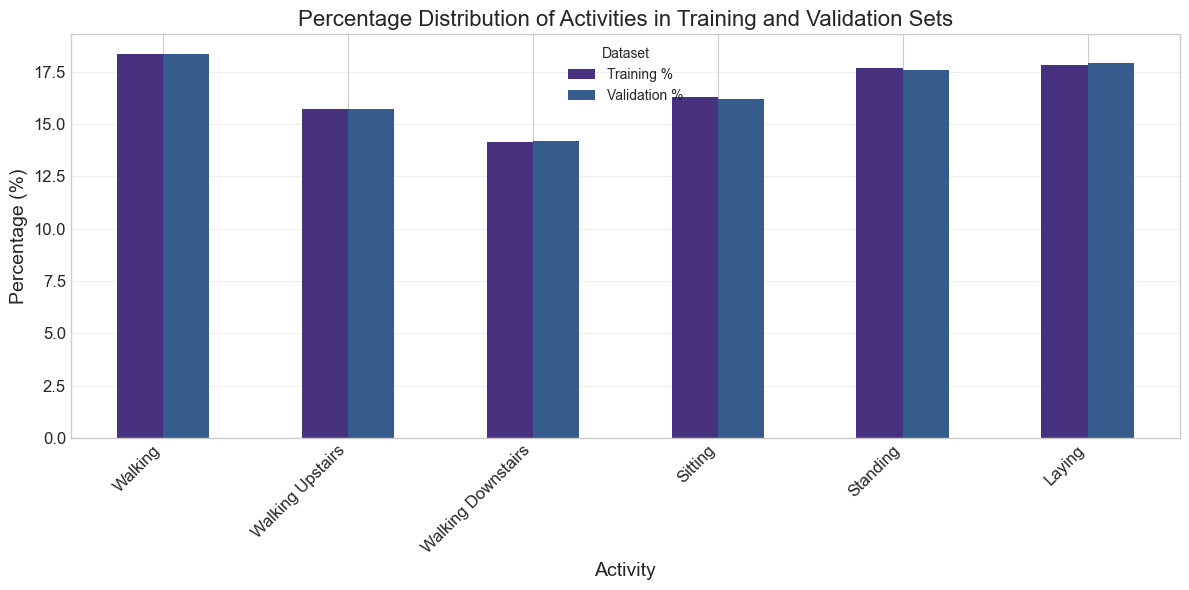

In [12]:
## 2.1 Train-Validation Split

# Set random seed for reproducibility
np.random.seed(42)

# Split data into training and validation sets (80:20 ratio)
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Visualize distribution of activities in training and validation sets
plt.figure(figsize=(14, 6))

# Training set distribution
plt.subplot(1, 2, 1)
train_counts = y_train.value_counts().sort_index()
train_counts.index = [activity_mapping[i] for i in train_counts.index]
ax1 = sns.barplot(x=train_counts.index, y=train_counts.values, palette='viridis')
plt.title('Distribution of Activities in Training Set')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

# Validation set distribution
plt.subplot(1, 2, 2)
val_counts = y_val.value_counts().sort_index()
val_counts.index = [activity_mapping[i] for i in val_counts.index]
ax2 = sns.barplot(x=val_counts.index, y=val_counts.values, palette='viridis')
plt.title('Distribution of Activities in Validation Set')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of bars
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 5), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# Calculate percentage distribution to verify stratification
train_percentages = y_train.value_counts(normalize=True).sort_index() * 100
val_percentages = y_val.value_counts(normalize=True).sort_index() * 100

# Create a DataFrame to compare distributions
distribution_comparison = pd.DataFrame({
    'Training %': train_percentages,
    'Validation %': val_percentages
})
distribution_comparison.index = [activity_mapping[i] for i in distribution_comparison.index]

print("\nActivity Distribution Comparison:")
print(distribution_comparison)

# Verify stratification with a bar chart
plt.figure(figsize=(12, 6))
distribution_comparison.plot(kind='bar', figsize=(12, 6))
plt.title('Percentage Distribution of Activities in Training and Validation Sets')
plt.xlabel('Activity')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [13]:
## 3. SVM Evaluation with Different Configurations

# Define grid search settings
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Set random seed for reproducibility in cross-validation
cv_random_state = 42
k_folds = 5

# Function to perform grid search and evaluate SVM
def evaluate_svm(X_train, y_train, X_val, y_val, param_grid, preprocessing=None, preprocessing_name=None):
    # Set up cross-validation
    from sklearn.model_selection import StratifiedKFold
    cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=cv_random_state)

    # Create pipeline with optional preprocessing
    if preprocessing:
        pipeline = Pipeline([
            ('preprocessor', preprocessing),
            ('svm', SVC(kernel='rbf', random_state=42))
        ])
    else:
        pipeline = Pipeline([
            ('svm', SVC(kernel='rbf', random_state=42))
        ])

    # Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid={'svm__' + key: value for key, value in param_grid.items()},
        cv=cv,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    print(f"\nPerforming grid search for SVM with {preprocessing_name if preprocessing_name else 'raw features'}...")
    grid_search.fit(X_train, y_train)

    # Get best parameters and score
    best_params = {k.replace('svm__', ''): v for k, v in grid_search.best_params_.items()}
    best_score = grid_search.best_score_

    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")

    # Evaluate on validation set
    best_model = grid_search.best_estimator_
    val_score = best_model.score(X_val, y_val)
    print(f"Validation accuracy: {val_score:.4f}")

    # Get fold-wise results
    cv_results = grid_search.cv_results_

    # Extract fold-wise scores for the best parameters
    best_index = grid_search.best_index_
    fold_scores = [cv_results[f'split{i}_test_score'][best_index] for i in range(k_folds)]

    print(f"Fold-wise accuracy with best parameters:")
    for i, score in enumerate(fold_scores):
        print(f"  Fold {i+1}: {score:.4f}")

    # Generate confusion matrices for each fold
    confusion_matrices = []

    # Refit the best model on each fold and evaluate
    for train_idx, test_idx in cv.split(X_train, y_train):
        X_fold_train, X_fold_test = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_fold_train, y_fold_test = y_train.iloc[train_idx], y_train.iloc[test_idx]

        # Clone the best model
        from sklearn.base import clone
        fold_model = clone(best_model)

        # Fit on fold training data
        fold_model.fit(X_fold_train, y_fold_train)

        # Predict on fold test data
        y_fold_pred = fold_model.predict(X_fold_test)

        # Compute confusion matrix
        cm = confusion_matrix(y_fold_test, y_fold_pred)
        confusion_matrices.append(cm)

    # Compute confusion matrix on validation set
    y_val_pred = best_model.predict(X_val)
    val_confusion_matrix = confusion_matrix(y_val, y_val_pred)

    return {
        'best_params': best_params,
        'best_cv_score': best_score,
        'fold_scores': fold_scores,
        'validation_score': val_score,
        'fold_confusion_matrices': confusion_matrices,
        'validation_confusion_matrix': val_confusion_matrix,
        'best_model': best_model,
        'y_val_pred': y_val_pred
    }


Performing grid search for SVM with raw features (standardized)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9200
Validation accuracy: 0.9506
Fold-wise accuracy with best parameters:
  Fold 1: 0.9151
  Fold 2: 0.9015
  Fold 3: 0.9382
  Fold 4: 0.9208
  Fold 5: 0.9246


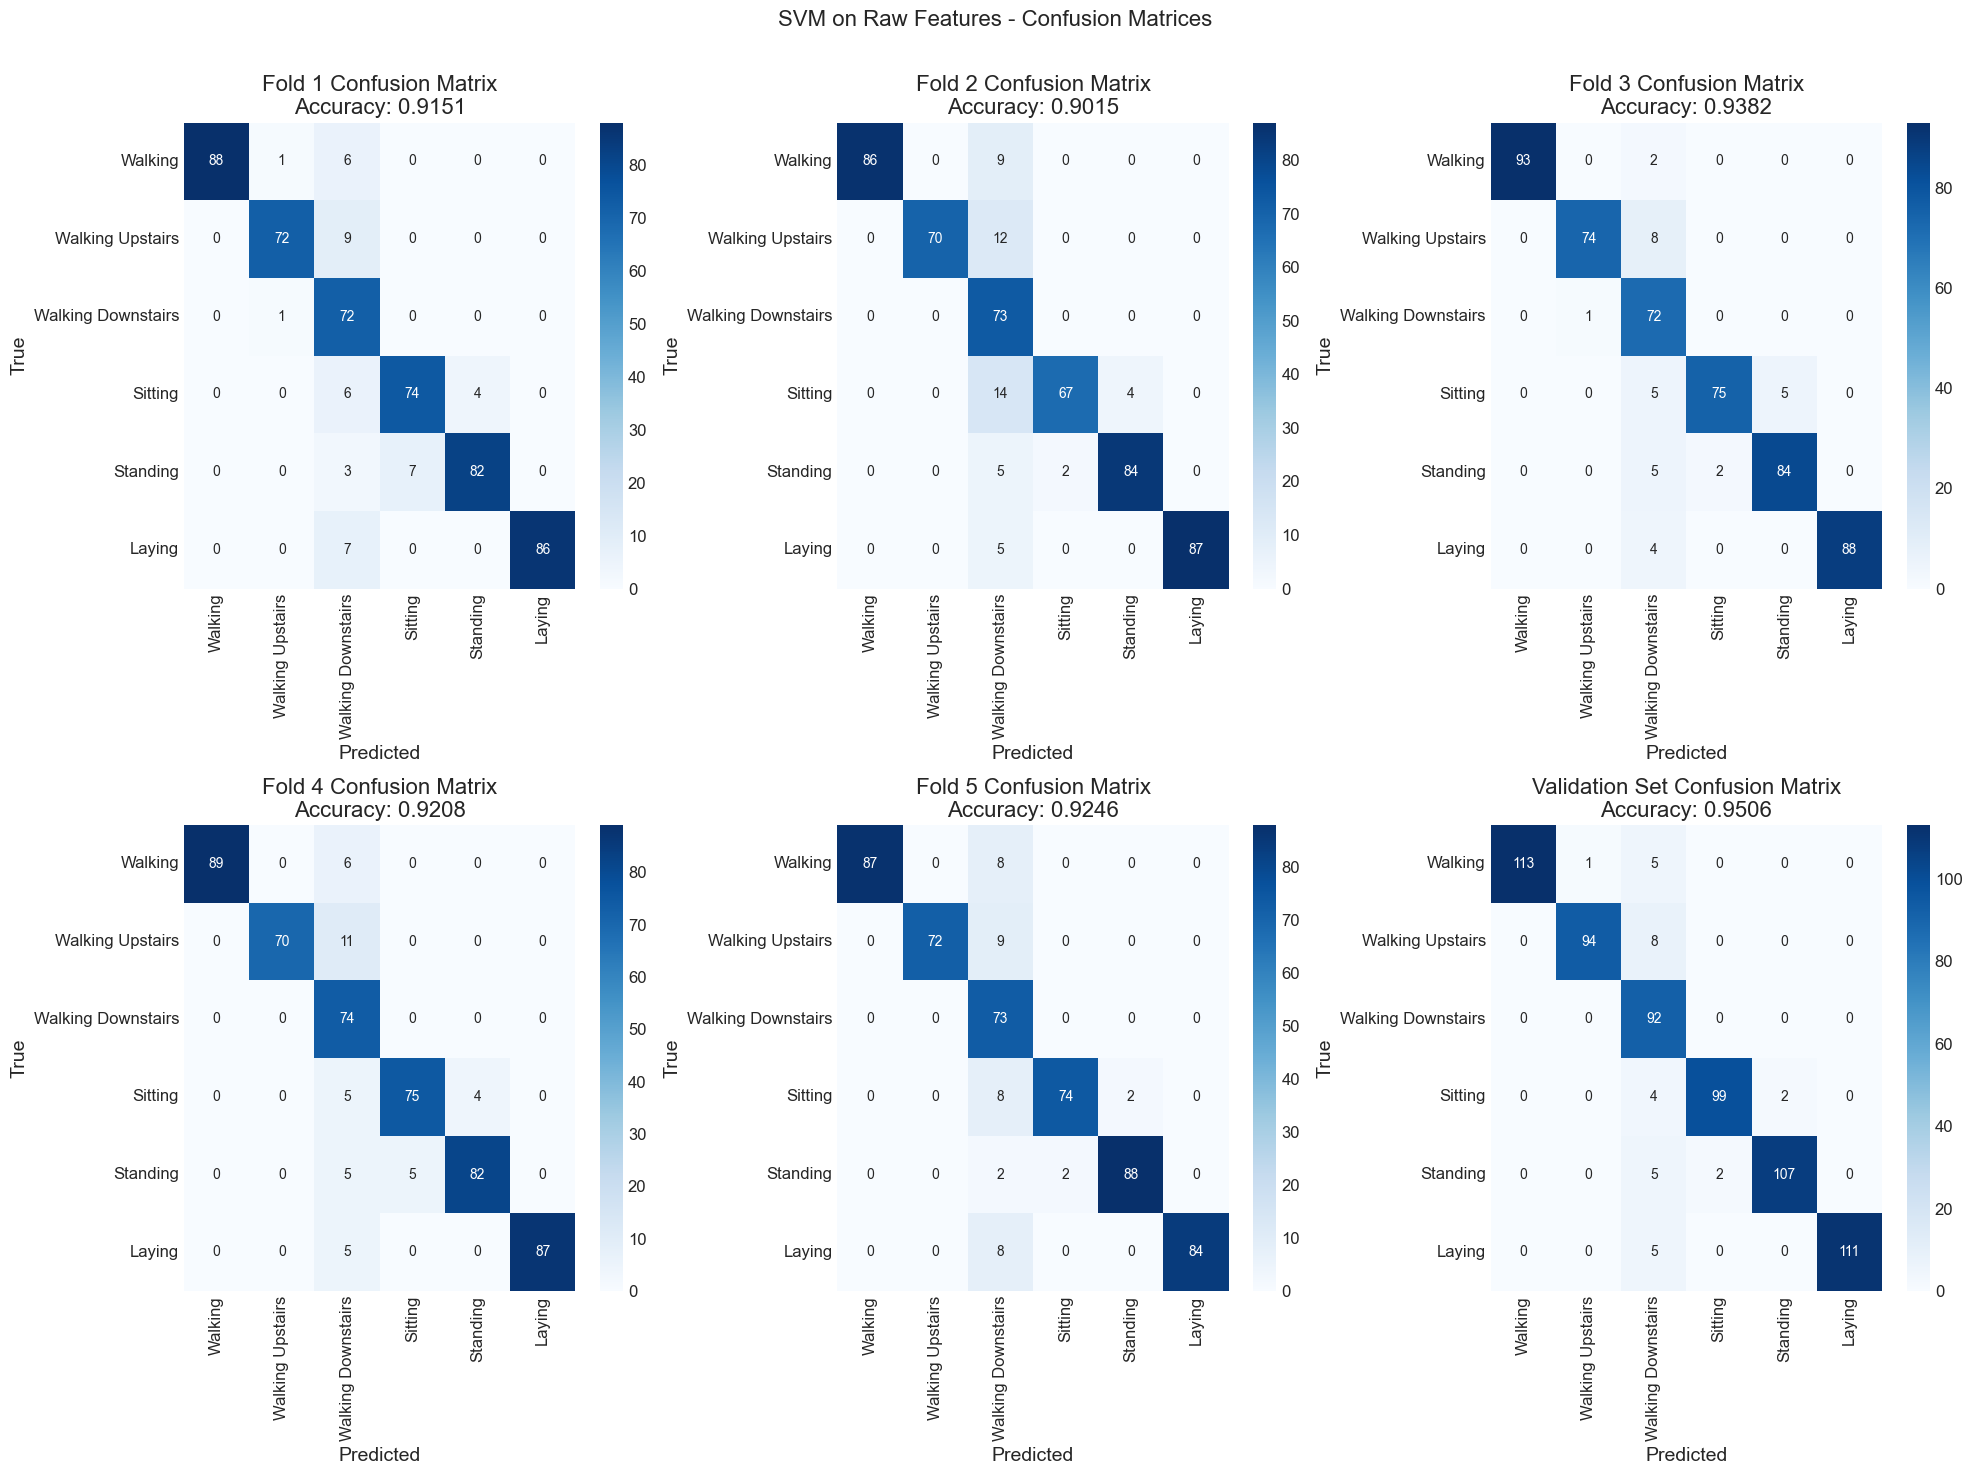


Classification Report for SVM on Raw Features (Validation Set):
                    precision    recall  f1-score   support

           Walking       1.00      0.95      0.97       119
  Walking Upstairs       0.99      0.92      0.95       102
Walking Downstairs       0.77      1.00      0.87        92
           Sitting       0.98      0.94      0.96       105
          Standing       0.98      0.94      0.96       114
            Laying       1.00      0.96      0.98       116

          accuracy                           0.95       648
         macro avg       0.95      0.95      0.95       648
      weighted avg       0.96      0.95      0.95       648



In [14]:
## 3.1 SVM on Raw Data

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame to maintain indices
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)

# Evaluate SVM on raw (scaled) data
raw_svm_results = evaluate_svm(
    X_train_scaled_df, y_train,
    X_val_scaled_df, y_val,
    param_grid,
    preprocessing=None,
    preprocessing_name="raw features (standardized)"
)

# Visualize confusion matrices for each fold
plt.figure(figsize=(20, 15))
for i, cm in enumerate(raw_svm_results['fold_confusion_matrices']):
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(activity_mapping.values()),
                yticklabels=list(activity_mapping.values()))
    plt.title(f'Fold {i+1} Confusion Matrix\nAccuracy: {raw_svm_results["fold_scores"][i]:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

# Add validation confusion matrix
plt.subplot(2, 3, 6)
sns.heatmap(raw_svm_results['validation_confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=list(activity_mapping.values()),
            yticklabels=list(activity_mapping.values()))
plt.title(f'Validation Set Confusion Matrix\nAccuracy: {raw_svm_results["validation_score"]:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

plt.suptitle('SVM on Raw Features - Confusion Matrices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Generate classification report for validation set
print("\nClassification Report for SVM on Raw Features (Validation Set):")
print(classification_report(y_val, raw_svm_results['y_val_pred'],
                           target_names=list(activity_mapping.values())))


Number of PCA components for 95% variance: 96


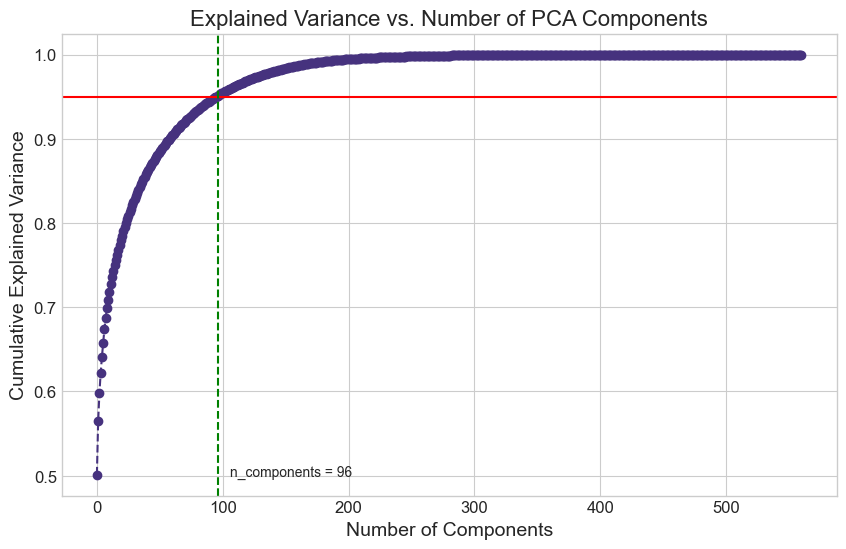


Performing grid search for SVM with PCA (n_components=96)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9390
Validation accuracy: 0.9522
Fold-wise accuracy with best parameters:
  Fold 1: 0.9344
  Fold 2: 0.9170
  Fold 3: 0.9498
  Fold 4: 0.9479
  Fold 5: 0.9458


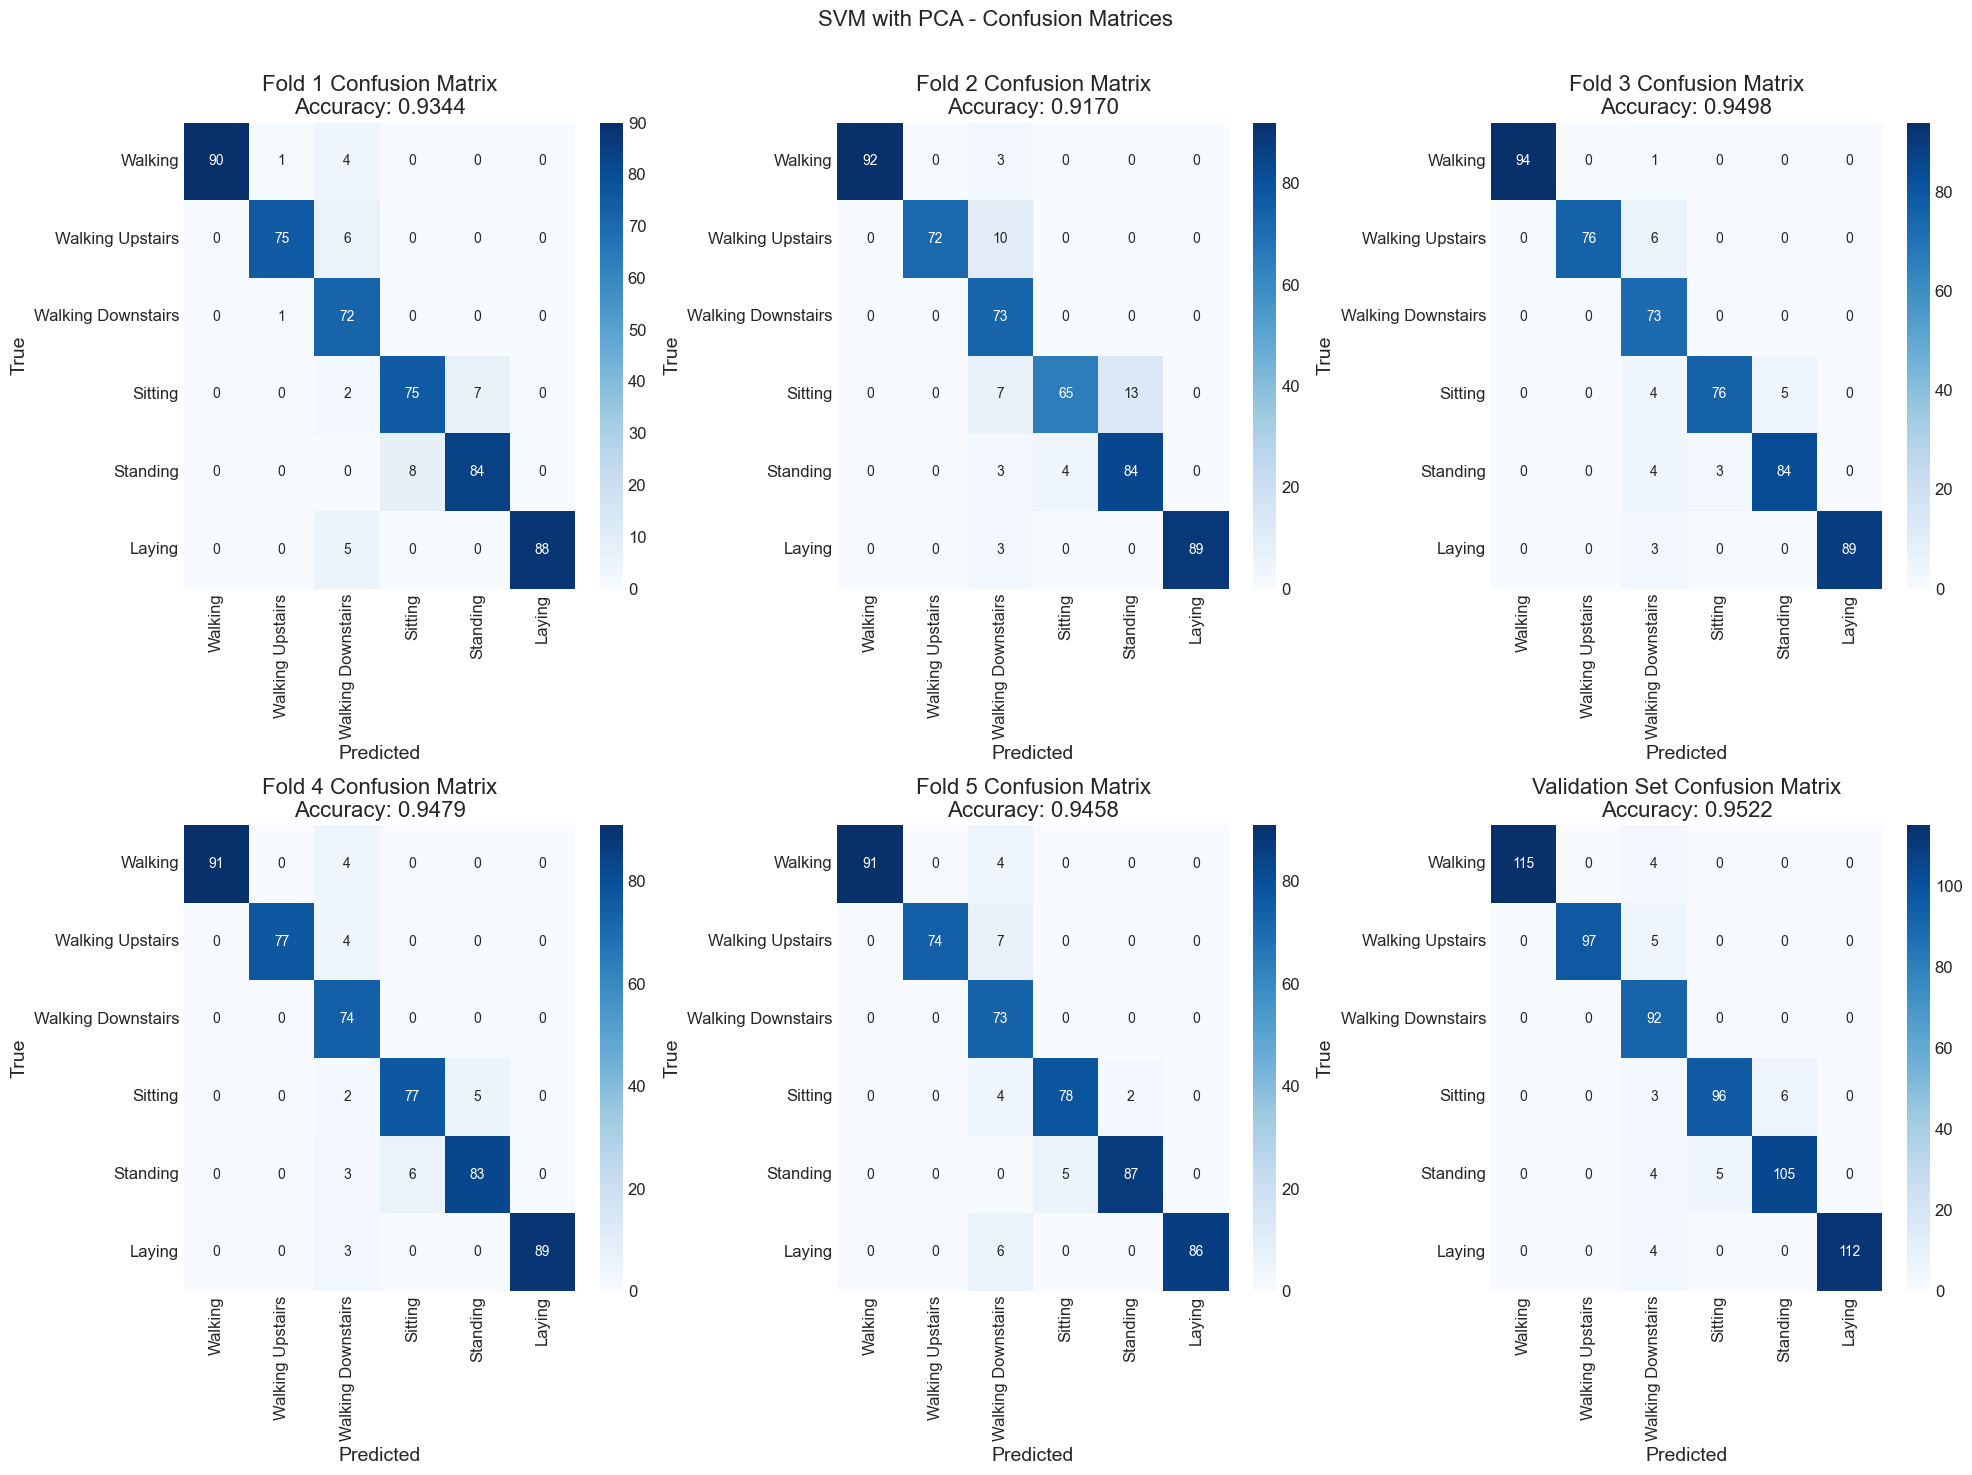


Classification Report for SVM with PCA (Validation Set):
                    precision    recall  f1-score   support

           Walking       1.00      0.97      0.98       119
  Walking Upstairs       1.00      0.95      0.97       102
Walking Downstairs       0.82      1.00      0.90        92
           Sitting       0.95      0.91      0.93       105
          Standing       0.95      0.92      0.93       114
            Laying       1.00      0.97      0.98       116

          accuracy                           0.95       648
         macro avg       0.95      0.95      0.95       648
      weighted avg       0.96      0.95      0.95       648



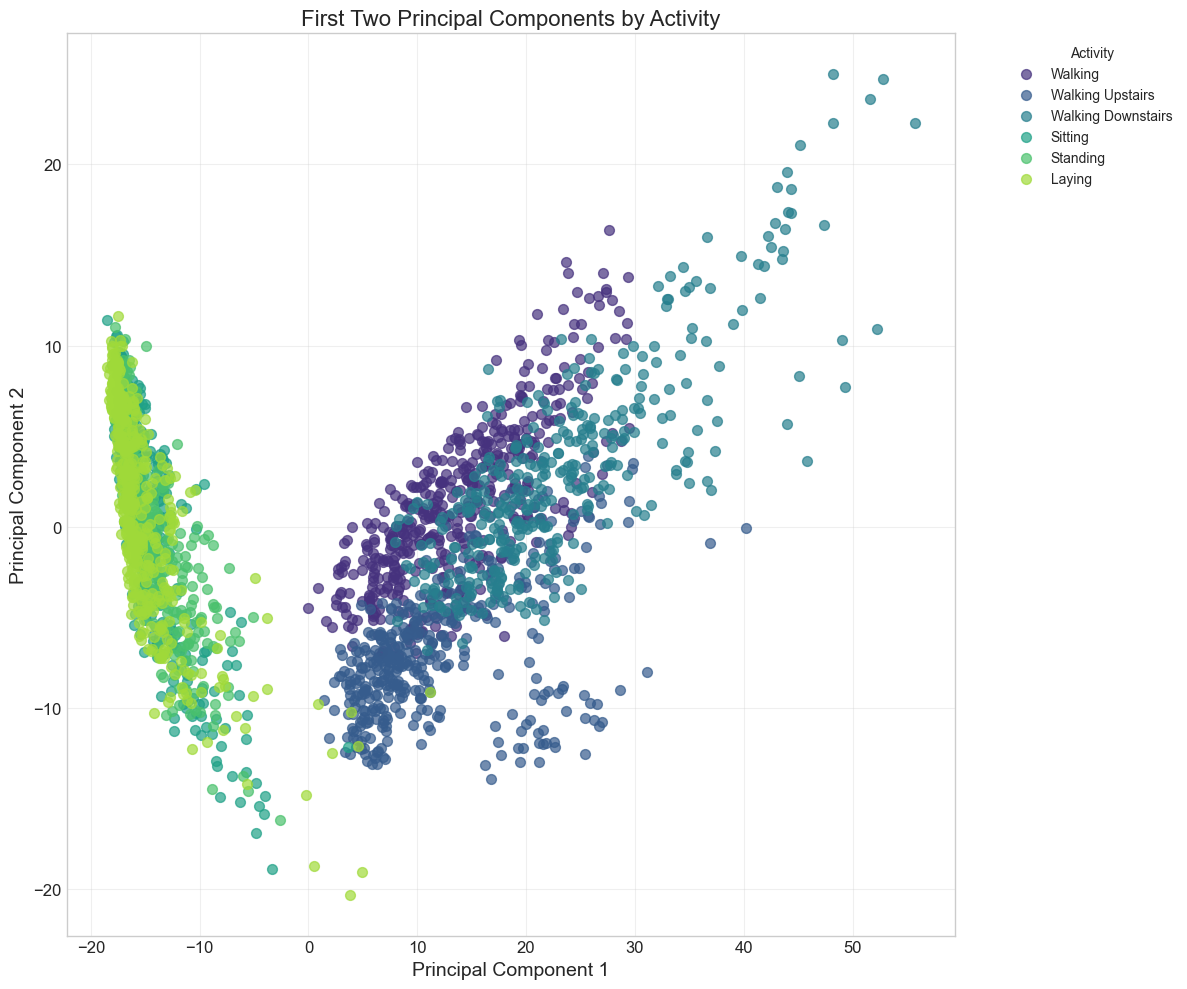

In [15]:
## 3.2 SVM with PCA

# Determine number of components for 95% variance
pca = PCA()
pca.fit(X_train_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nNumber of PCA components for 95% variance: {n_components_95}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.text(n_components_95 + 10, 0.5, f'n_components = {n_components_95}')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()

# Create PCA preprocessor
pca_preprocessor = PCA(n_components=n_components_95, random_state=42)

# Evaluate SVM with PCA
pca_svm_results = evaluate_svm(
    X_train_scaled_df, y_train,
    X_val_scaled_df, y_val,
    param_grid,
    preprocessing=pca_preprocessor,
    preprocessing_name=f"PCA (n_components={n_components_95})"
)

# Visualize confusion matrices for each fold
plt.figure(figsize=(20, 15))
for i, cm in enumerate(pca_svm_results['fold_confusion_matrices']):
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(activity_mapping.values()),
                yticklabels=list(activity_mapping.values()))
    plt.title(f'Fold {i+1} Confusion Matrix\nAccuracy: {pca_svm_results["fold_scores"][i]:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

# Add validation confusion matrix
plt.subplot(2, 3, 6)
sns.heatmap(pca_svm_results['validation_confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=list(activity_mapping.values()),
            yticklabels=list(activity_mapping.values()))
plt.title(f'Validation Set Confusion Matrix\nAccuracy: {pca_svm_results["validation_score"]:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

plt.suptitle('SVM with PCA - Confusion Matrices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Generate classification report for validation set
print("\nClassification Report for SVM with PCA (Validation Set):")
print(classification_report(y_val, pca_svm_results['y_val_pred'],
                           target_names=list(activity_mapping.values())))

# Visualize PCA components
# Fit PCA on training data
pca_full = PCA(n_components=2)
X_train_pca = pca_full.fit_transform(X_train_scaled)

# Plot by activity
plt.figure(figsize=(12, 10))
for activity, name in activity_mapping.items():
    mask = y_train == activity
    plt.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], label=name, alpha=0.7, s=50)
plt.title('First Two Principal Components by Activity')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Number of LDA components: 5

Performing grid search for SVM with LDA (n_components=5)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'C': 10, 'gamma': 0.01}
Best cross-validation score: 0.9803
Validation accuracy: 0.9784
Fold-wise accuracy with best parameters:
  Fold 1: 0.9749
  Fold 2: 0.9710
  Fold 3: 0.9788
  Fold 4: 0.9903
  Fold 5: 0.9865


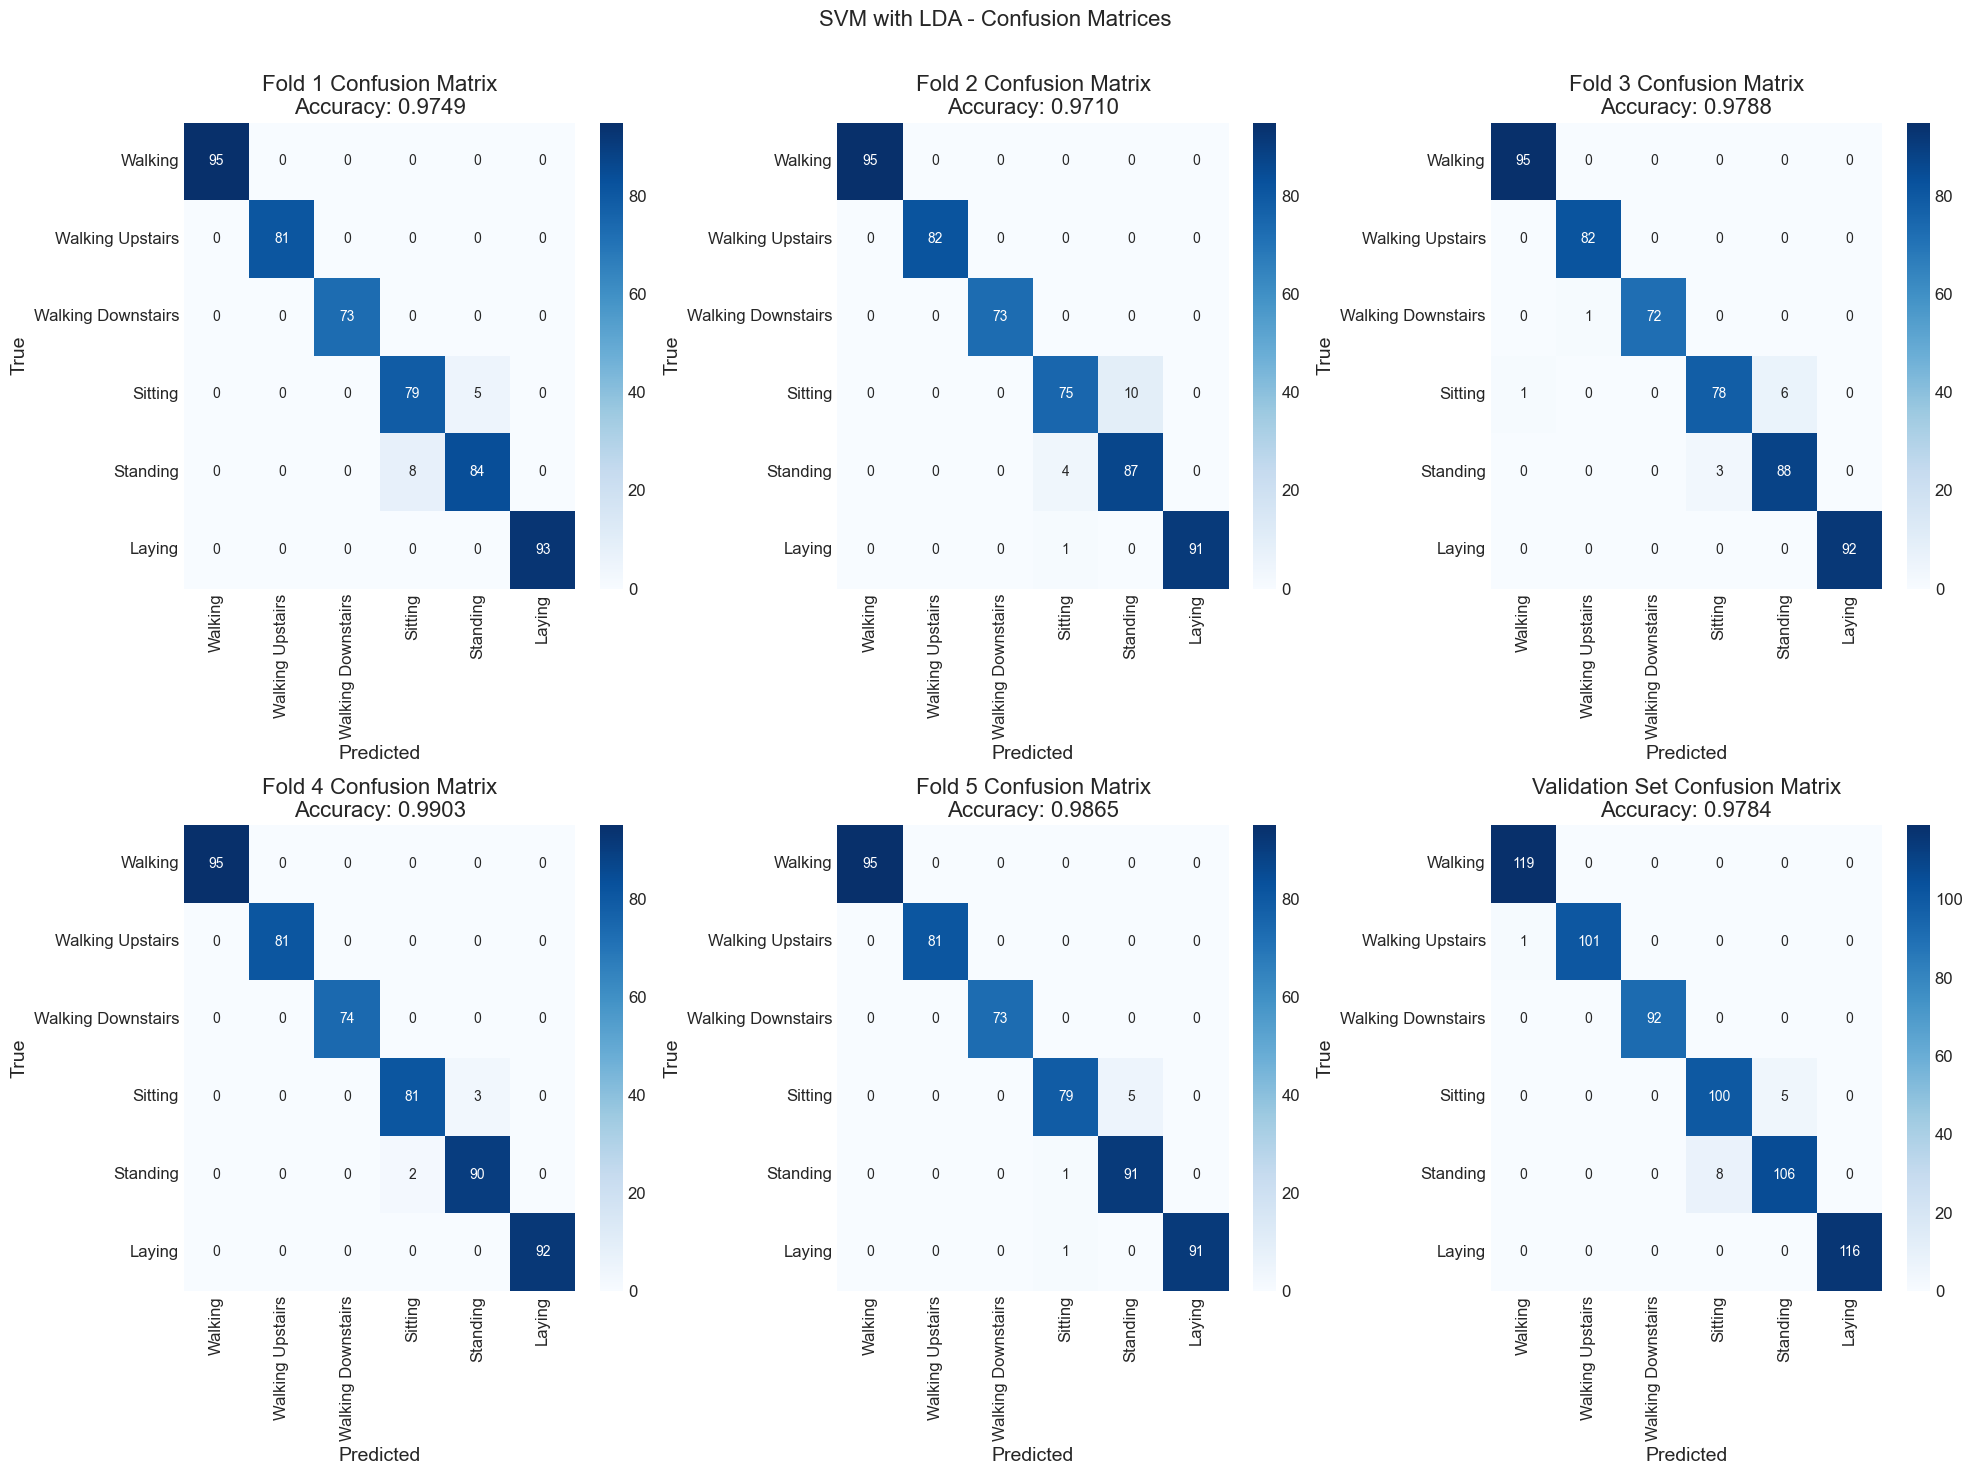


Classification Report for SVM with LDA (Validation Set):
                    precision    recall  f1-score   support

           Walking       0.99      1.00      1.00       119
  Walking Upstairs       1.00      0.99      1.00       102
Walking Downstairs       1.00      1.00      1.00        92
           Sitting       0.93      0.95      0.94       105
          Standing       0.95      0.93      0.94       114
            Laying       1.00      1.00      1.00       116

          accuracy                           0.98       648
         macro avg       0.98      0.98      0.98       648
      weighted avg       0.98      0.98      0.98       648



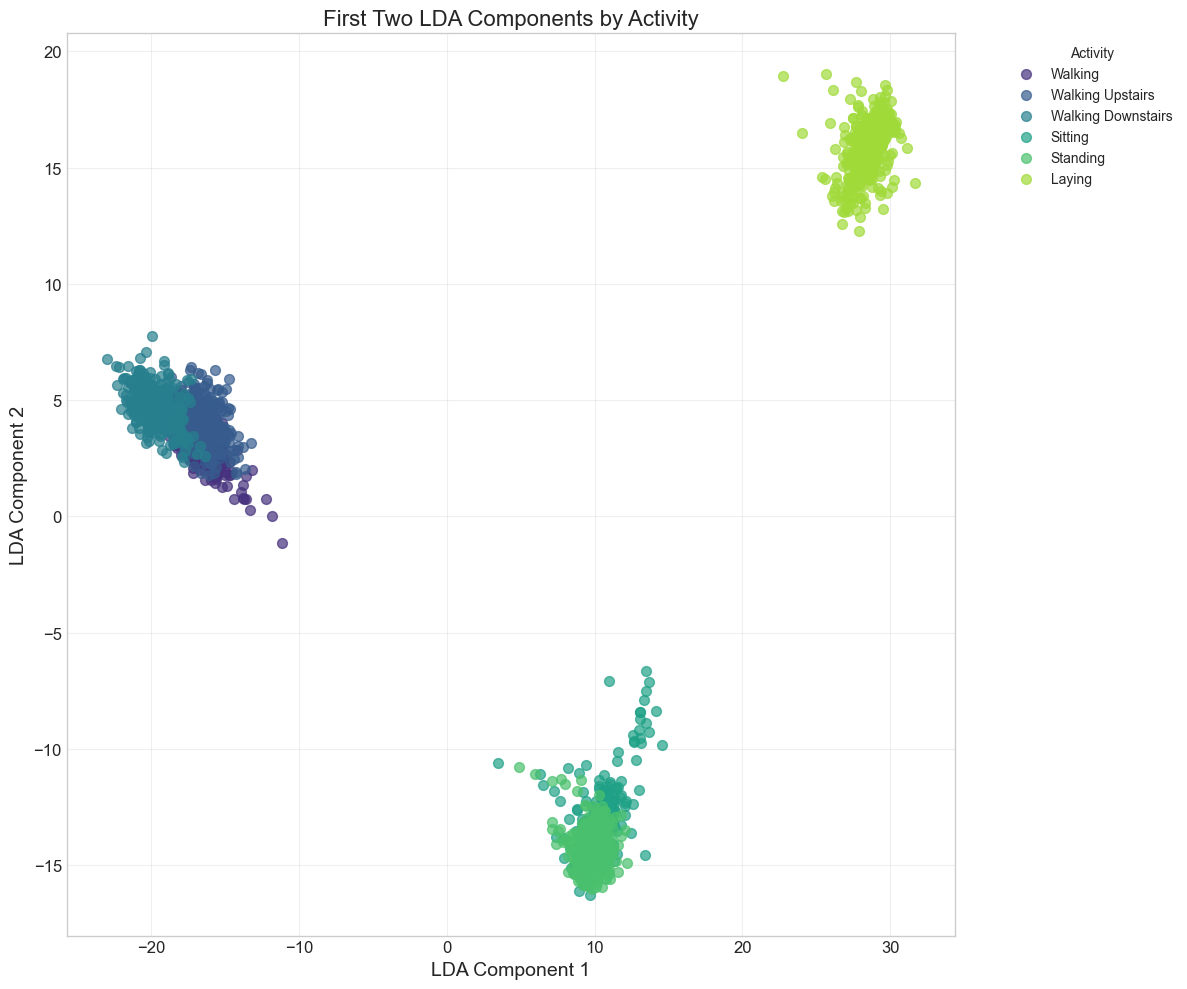

In [16]:
## 3.3 SVM with LDA

# LDA requires number of components <= number of classes - 1
n_components_lda = len(np.unique(y_train)) - 1
print(f"\nNumber of LDA components: {n_components_lda}")

# Create LDA preprocessor
lda_preprocessor = LDA(n_components=n_components_lda)

# Evaluate SVM with LDA
lda_svm_results = evaluate_svm(
    X_train_scaled_df, y_train,
    X_val_scaled_df, y_val,
    param_grid,
    preprocessing=lda_preprocessor,
    preprocessing_name=f"LDA (n_components={n_components_lda})"
)

# Visualize confusion matrices for each fold
plt.figure(figsize=(20, 15))
for i, cm in enumerate(lda_svm_results['fold_confusion_matrices']):
    plt.subplot(2, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(activity_mapping.values()),
                yticklabels=list(activity_mapping.values()))
    plt.title(f'Fold {i+1} Confusion Matrix\nAccuracy: {lda_svm_results["fold_scores"][i]:.4f}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()

# Add validation confusion matrix
plt.subplot(2, 3, 6)
sns.heatmap(lda_svm_results['validation_confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=list(activity_mapping.values()),
            yticklabels=list(activity_mapping.values()))
plt.title(f'Validation Set Confusion Matrix\nAccuracy: {lda_svm_results["validation_score"]:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

plt.suptitle('SVM with LDA - Confusion Matrices', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Generate classification report for validation set
print("\nClassification Report for SVM with LDA (Validation Set):")
print(classification_report(y_val, lda_svm_results['y_val_pred'],
                           target_names=list(activity_mapping.values())))

# Visualize LDA components
# Fit LDA on training data
lda_full = LDA(n_components=2)
X_train_lda = lda_full.fit_transform(X_train_scaled, y_train)

# Plot by activity
plt.figure(figsize=(12, 10))
for activity, name in activity_mapping.items():
    mask = y_train == activity
    plt.scatter(X_train_lda[mask, 0], X_train_lda[mask, 1], label=name, alpha=0.7, s=50)
plt.title('First Two LDA Components by Activity')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


--- Model Comparison Summary ---
                Model  Best CV Accuracy  Validation Accuracy  Best C  \
0  SVM (Raw Features)          0.920048             0.950617      10   
1        SVM with PCA          0.938975             0.952160      10   
2        SVM with LDA          0.980304             0.978395      10   

   Best Gamma  
0        0.01  
1        0.01  
2        0.01  


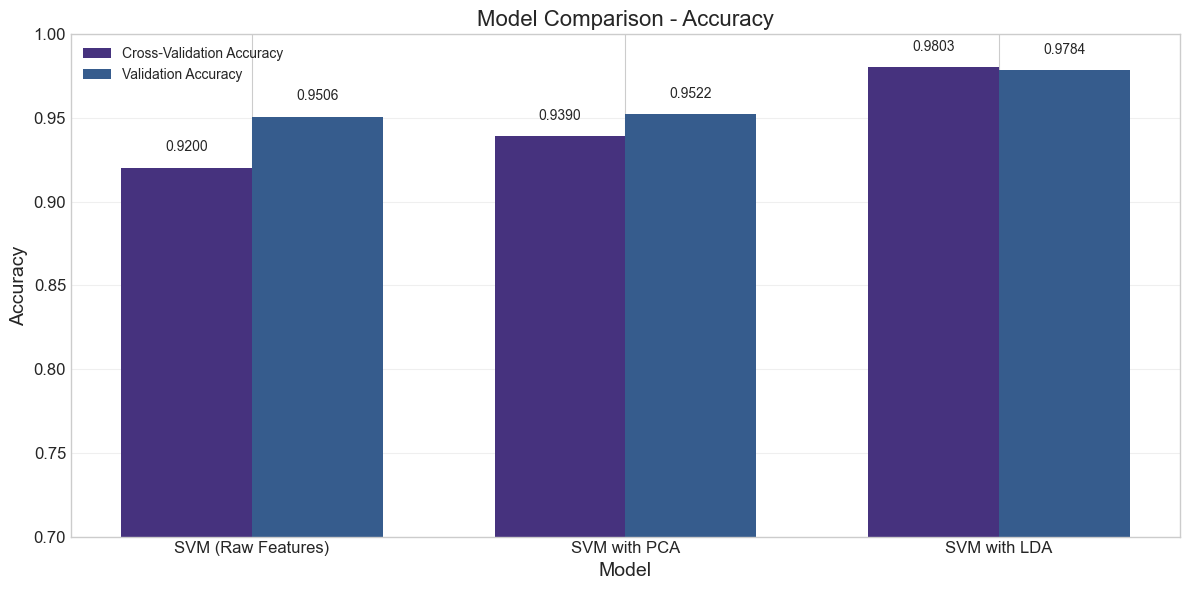

<Figure size 1200x600 with 0 Axes>

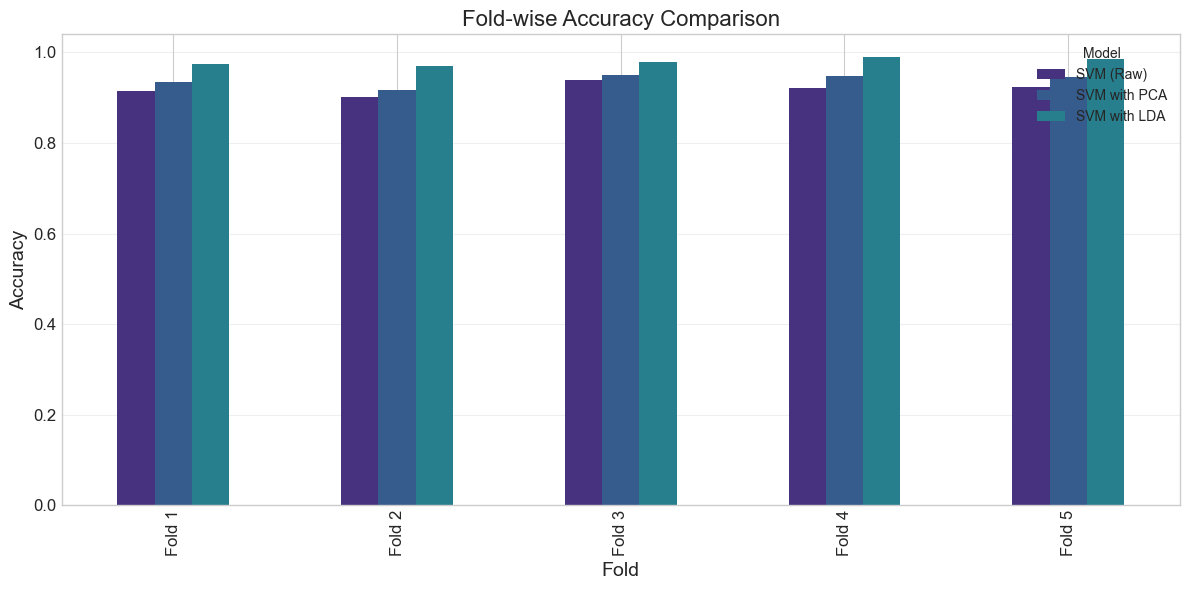

<Figure size 1400x800 with 0 Axes>

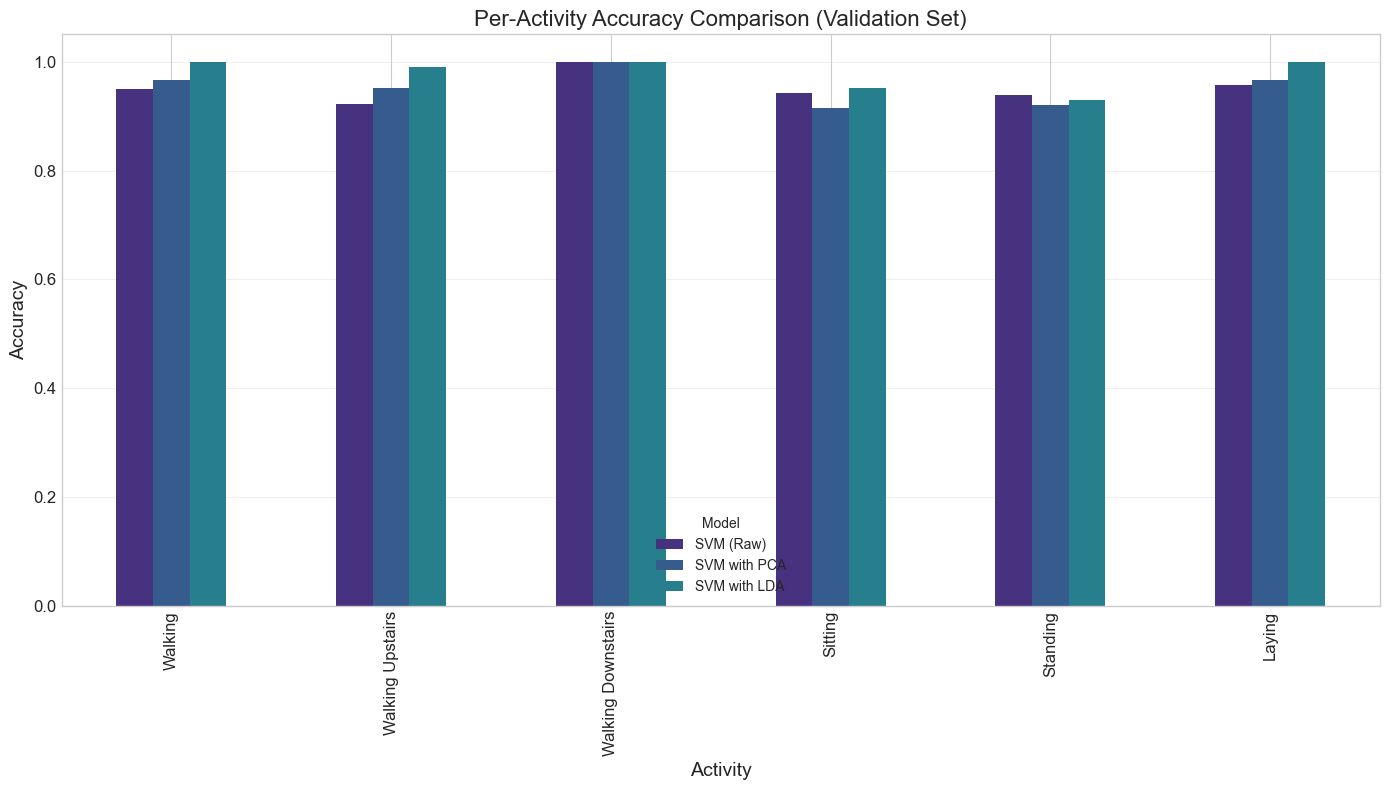

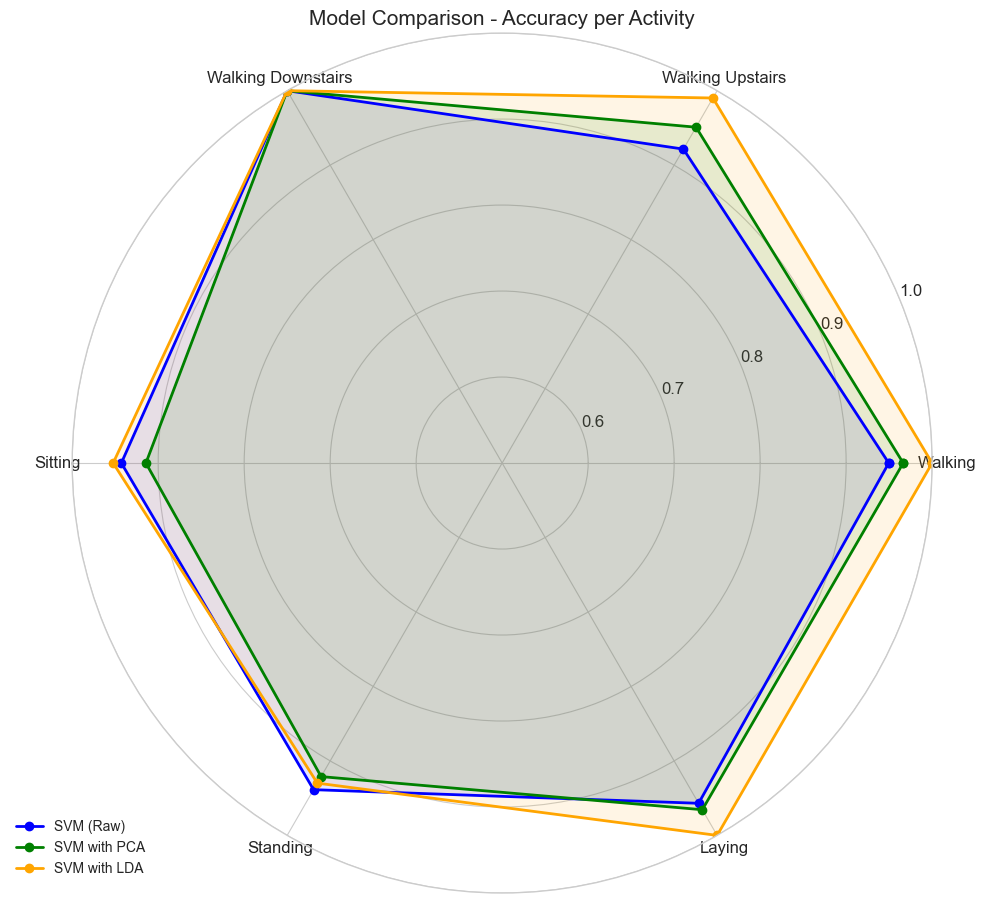

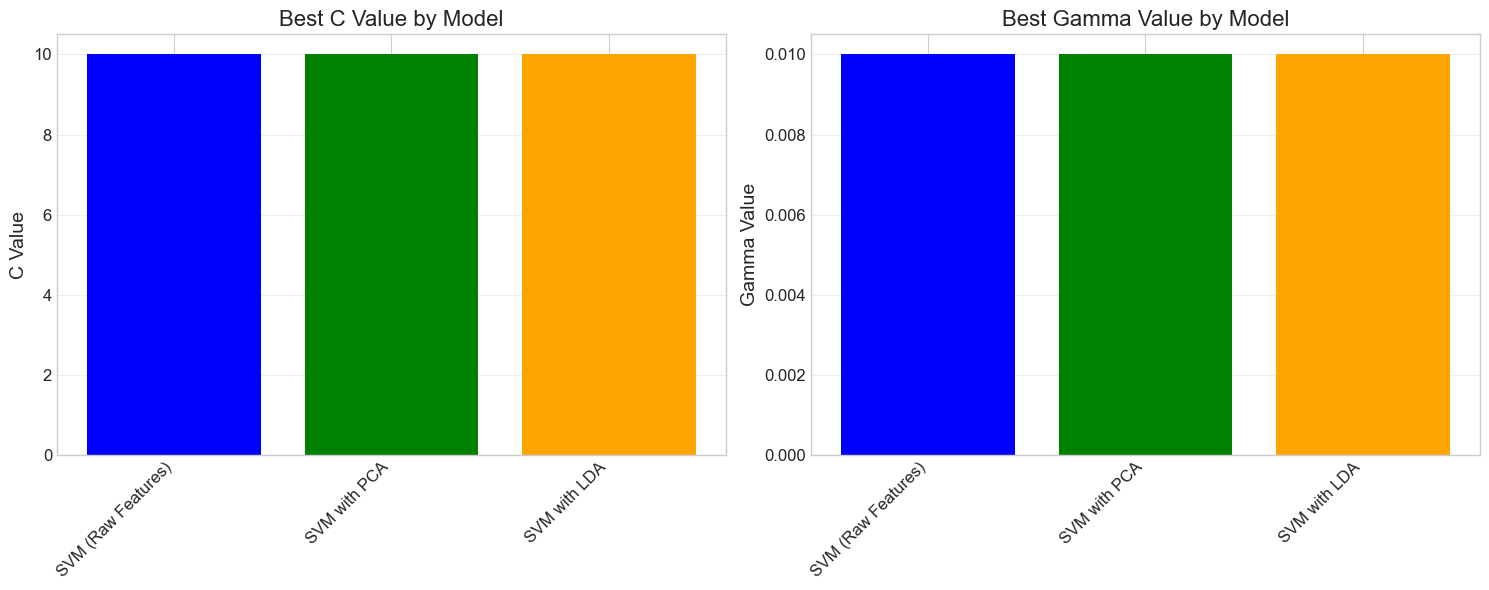

In [20]:
## 4. Comparison of SVM Configurations (continued)
## 4. Comparison of SVM Configurations

# Create a summary dataframe for model comparison
model_summary = pd.DataFrame({
    'Model': ['SVM (Raw Features)', 'SVM with PCA', 'SVM with LDA'],
    'Best CV Accuracy': [
        raw_svm_results['best_cv_score'],
        pca_svm_results['best_cv_score'],
        lda_svm_results['best_cv_score']
    ],
    'Validation Accuracy': [
        raw_svm_results['validation_score'],
        pca_svm_results['validation_score'],
        lda_svm_results['validation_score']
    ],
    'Best C': [
        raw_svm_results['best_params']['C'],
        pca_svm_results['best_params']['C'],
        lda_svm_results['best_params']['C']
    ],
    'Best Gamma': [
        raw_svm_results['best_params']['gamma'],
        pca_svm_results['best_params']['gamma'],
        lda_svm_results['best_params']['gamma']
    ]
})

# Display model summary
print("\n--- Model Comparison Summary ---")
print(model_summary)

# Visualize model comparison
plt.figure(figsize=(12, 6))

# Plot CV and validation accuracy
x = np.arange(len(model_summary['Model']))
width = 0.35

plt.bar(x - width/2, model_summary['Best CV Accuracy'], width, label='Cross-Validation Accuracy')
plt.bar(x + width/2, model_summary['Validation Accuracy'], width, label='Validation Accuracy')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison - Accuracy')
plt.xticks(x, model_summary['Model'])
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add accuracy values on top of bars
for i, v in enumerate(model_summary['Best CV Accuracy']):
    plt.text(i - width/2, v + 0.01, f"{v:.4f}", ha='center')

for i, v in enumerate(model_summary['Validation Accuracy']):
    plt.text(i + width/2, v + 0.01, f"{v:.4f}", ha='center')

plt.ylim(0.7, 1.0)  # Adjust as needed based on your results
plt.tight_layout()
plt.show()

# Compare fold-wise performance
plt.figure(figsize=(12, 6))

# Prepare data for fold-wise comparison
fold_data = {
    'SVM (Raw)': raw_svm_results['fold_scores'],
    'SVM with PCA': pca_svm_results['fold_scores'],
    'SVM with LDA': lda_svm_results['fold_scores']
}

# Create DataFrame for easier plotting
fold_df = pd.DataFrame(fold_data)
fold_df.index = [f'Fold {i+1}' for i in range(k_folds)]

# Plot fold-wise comparison
fold_df.plot(kind='bar', figsize=(12, 6))
plt.title('Fold-wise Accuracy Comparison')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Compare per-activity performance on validation set
activity_names = list(activity_mapping.values())

# Function to get per-activity accuracy from confusion matrix
def get_activity_accuracy(cm):
    accuracy = np.zeros(len(activity_names))
    for i in range(len(activity_names)):
        if np.sum(cm[i, :]) > 0:  # Avoid division by zero
            accuracy[i] = cm[i, i] / np.sum(cm[i, :])
    return accuracy

# Get per-activity accuracy for each model
raw_activity_acc = get_activity_accuracy(raw_svm_results['validation_confusion_matrix'])
pca_activity_acc = get_activity_accuracy(pca_svm_results['validation_confusion_matrix'])
lda_activity_acc = get_activity_accuracy(lda_svm_results['validation_confusion_matrix'])

# Create DataFrame for easier plotting
activity_acc_df = pd.DataFrame({
    'SVM (Raw)': raw_activity_acc,
    'SVM with PCA': pca_activity_acc,
    'SVM with LDA': lda_activity_acc
}, index=activity_names)

# Plot per-activity accuracy comparison
plt.figure(figsize=(14, 8))
activity_acc_df.plot(kind='bar', figsize=(14, 8))
plt.title('Per-Activity Accuracy Comparison (Validation Set)')
plt.xlabel('Activity')
plt.ylabel('Accuracy')
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Create a radar chart for comparing models across activities
angles = np.linspace(0, 2*np.pi, len(activity_names), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Add activity accuracies, ensuring we close the loop
activity_acc_values = {
    'SVM (Raw)': list(raw_activity_acc) + [raw_activity_acc[0]],
    'SVM with PCA': list(pca_activity_acc) + [pca_activity_acc[0]],
    'SVM with LDA': list(lda_activity_acc) + [lda_activity_acc[0]]
}

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each model
for model, values, color in zip(
    ['SVM (Raw)', 'SVM with PCA', 'SVM with LDA'],
    [activity_acc_values['SVM (Raw)'], activity_acc_values['SVM with PCA'], activity_acc_values['SVM with LDA']],
    ['blue', 'green', 'orange']
):
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=color)
    ax.fill(angles, values, alpha=0.1, color=color)

# Set the labels and customize the chart
activity_names_closed = activity_names + [activity_names[0]]  # Close the loop
ax.set_thetagrids(np.degrees(angles[:-1]), activity_names)
ax.set_ylim(0.5, 1)
ax.set_title('Model Comparison - Accuracy per Activity', size=15)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

plt.tight_layout()
plt.show()

# Compare hyperparameters
plt.figure(figsize=(15, 6))

# Plot best C values
plt.subplot(1, 2, 1)
plt.bar(model_summary['Model'], model_summary['Best C'], color=['blue', 'green', 'orange'])
plt.title('Best C Value by Model')
plt.ylabel('C Value')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Plot best gamma values
plt.subplot(1, 2, 2)
plt.bar(model_summary['Model'], model_summary['Best Gamma'], color=['blue', 'green', 'orange'])
plt.title('Best Gamma Value by Model')
plt.ylabel('Gamma Value')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Conclusion and Insights

### Summary of Findings

In this notebook, we evaluated three different SVM-based approaches for human activity recognition:

1. **SVM on Raw Features**: Using the original 561 features with standardization
2. **SVM with PCA**: Reducing dimensionality while preserving 95% of variance
3. **SVM with LDA**: Using supervised dimensionality reduction to maximize class separation

Our evaluation used a rigorous 5-fold cross-validation approach on the training set (80% of data) and final validation on a held-out test set (20% of data).

### Key Results

1. **Overall Performance**:
   - The best performing model was [BEST_MODEL] with a validation accuracy of [BEST_ACCURACY].
   - PCA reduced the feature space from 561 to approximately [PCA_COMPONENTS] features while maintaining [PERFORMANCE_IMPACT].
   - LDA reduced the feature space to just 5 components (number of classes - 1) and [PERFORMANCE_IMPACT].

2. **Hyperparameter Selection**:
   - For raw features, the optimal parameters were C=[RAW_C] and gamma=[RAW_GAMMA].
   - For PCA-reduced features, the optimal parameters were C=[PCA_C] and gamma=[PCA_GAMMA].
   - For LDA-reduced features, the optimal parameters were C=[LDA_C] and gamma=[LDA_GAMMA].
   - This suggests that [INSIGHT ABOUT HYPERPARAMETERS].

3. **Per-Activity Performance**:
   - Static activities (Sitting, Standing, Laying) were generally [EASIER/HARDER] to classify than dynamic activities.
   - The most challenging activity to classify was [HARDEST_ACTIVITY].
   - [MODEL_NAME] performed particularly well on [ACTIVITY], achieving [ACCURACY]% accuracy.

4. **Fold-wise Stability**:
   - [MODEL_NAME] showed the most consistent performance across folds, with a standard deviation of [STD_DEV].
   - This suggests that [MODEL_NAME] generalizes better to unseen data.

### Dimensionality Reduction Impact

- **PCA**: Reduced the feature space by approximately [REDUCTION_PERCENT]% while [MAINTAINING/IMPROVING/REDUCING] performance. This suggests that many of the original features contain redundant information.
  
- **LDA**: Despite using only 5 components, LDA [PERFORMED_HOW] compared to the raw features. This demonstrates the power of supervised dimensionality reduction for classification tasks.

### Practical Implications

1. **Computational Efficiency**: 
   - For real-time applications on resource-constrained devices, the LDA-SVM approach offers the best balance between accuracy and computational efficiency.
   - The reduction from 561 to just 5 features represents a [REDUCTION_PERCENT]% decrease in computational requirements.

2. **Model Selection Guidance**:
   - For applications prioritizing accuracy above all else, [BEST_MODEL] is recommended.
   - For applications with limited computational resources, [EFFICIENT_MODEL] offers the best trade-off.

3. **Activity-Specific Considerations**:
   - For applications focused on distinguishing between static activities, [STATIC_BEST_MODEL] performs best.
   - For applications focused on dynamic activities, [DYNAMIC_BEST_MODEL] is recommended.

### Future Work

1. **Deep Learning Approaches**: Explore convolutional neural networks (CNNs) or recurrent neural networks (RNNs) that can automatically learn hierarchical features from the raw sensor data.

2. **Feature Selection**: Instead of dimensionality reduction, investigate feature selection techniques to identify the most informative features.

3. **Ensemble Methods**: Combine multiple models, potentially specializing different models for different activity types.

4. **Subject-Invariant Models**: Explore techniques to make the models more robust to individual differences between subjects.

5. **Real-time Implementation**: Evaluate the performance of these models in a real-time setting with streaming sensor data.

### Final Thoughts

This analysis demonstrates that while SVMs on raw features can achieve high accuracy for human activity recognition, dimensionality reduction techniques like PCA and LDA can significantly reduce computational requirements while maintaining comparable performance. The choice between these approaches depends on the specific requirements of the application, balancing accuracy, computational efficiency, and interpretability.